# Notebook 6: Basic Data Analysis and Machine Learning

## Overview

This notebook demonstrates **exploratory data analysis (EDA) and machine learning classification** on preprocessed FTIR spectral data. You'll visualize spectral patterns, perform statistical analysis, apply dimensionality reduction, and build classification models.

### What You'll Learn

1. How to load and filter preprocessed FTIR data
2. How to visualize spectral patterns and variability
3. How to perform statistical analysis (ANOVA, correlation)
4. How to apply dimensionality reduction (PCA, t-SNE, UMAP, PLS-DA, OPLS-DA)
5. How to perform clustering analysis (K-means, hierarchical)
6. How to train and evaluate machine learning classification models
7. How to interpret model predictions with SHAP

### Prerequisites

You should have already:
- ✓ Completed Notebooks 1-5 OR have preprocessed FTIR data ready
- ✓ Data in CSV format with a label column (polymer type)
- ✓ Preprocessed data (denoised, baseline corrected, normalized)

### Analysis Workflow

This notebook follows a systematic analysis workflow:

1. **Data Loading & Filtering**: Load preprocessed data and select samples
2. **Exploratory Visualization**: Visualize spectral patterns and variability
3. **Statistical Analysis**: Identify significant wavenumbers (ANOVA, correlation)
4. **Dimensionality Reduction**: Reduce high-dimensional data for visualization
5. **Clustering Analysis**: Discover natural groupings in the data
6. **Machine Learning**: Build and evaluate classification models
7. **Model Interpretation**: Understand what drives predictions (SHAP)

### Available Analysis Methods

The `FTIRdataanalysis` class provides:

**Visualization:**
- Mean spectra by polymer type
- Overlay plots for comparison
- Coefficient of variation (CV) plots
- Correlation heatmaps

**Statistical Analysis:**
- ANOVA (identify discriminative wavenumbers)
- Correlation analysis

**Dimensionality Reduction:**
- PCA (Principal Component Analysis)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- UMAP (Uniform Manifold Approximation and Projection)
- PLS-DA (Partial Least Squares Discriminant Analysis)
- OPLS-DA (Orthogonal PLS-DA)

**Clustering:**
- K-means clustering
- Hierarchical clustering

**Machine Learning:**
- 35+ pre-configured classification models
- Automated model comparison
- Hyperparameter tuning
- SHAP explainability analysis

### Expected Output

By the end of this notebook, you'll have:
- Visual understanding of spectral patterns
- Statistical insights into discriminative features
- Low-dimensional representations for visualization
- Trained classification models with performance metrics
- Interpretation of model predictions

---

## Step 1: Load Preprocessed Data

First, we'll load the preprocessed FTIR data created in previous notebooks.

In [1]:
# Import required modules
import polars as pl
import pandas as pd
from xpectrass import FTIRdataanalysis

print("="*80)
print("LOADING PREPROCESSED DATA")
print("="*80)

LOADING PREPROCESSED DATA


In [2]:
# Load the preprocessed data from Notebook 5
# Using 1st derivative data for enhanced spectral resolution
df = pd.read_csv('processed_data/combined_deriv1_data.csv.xz', compression='xz')

print(f"\nLoaded data shape: {df.shape}")
print(f"\nAvailable studies:")
print(df['study'].unique())
print("\nFirst few rows:")
print(df.head())


Loaded data shape: (12214, 1166)

Available studies:
['jung_2018' 'kedzierski_2019' 'kedzierski_2019_u' 'frond_2021'
 'villegas_camacho_2024_c4' 'villegas_camacho_2024_c8']

First few rows:
       study       sample_id  type environmental resolution  3000.0000  \
0  jung_2018   LL477006_1.16  HDPE             Y          H  -0.000274   
1  jung_2018   LL477006_5.15  HDPE             Y          H  -0.000307   
2  jung_2018   LL477006_6.01  HDPE             Y          H   0.000092   
3  jung_2018   LL477006_7.01  HDPE             Y          H  -0.000306   
4  jung_2018  LL477006_14.01  HDPE             Y          H  -0.000209   

   2998.0000  2996.0000  2994.0000  2992.0000  ...  698.0000  696.0000  \
0  -0.000292  -0.000306  -0.000317  -0.000320  ...  0.018877  0.013585   
1  -0.000328  -0.000341  -0.000346  -0.000354  ...  0.019549  0.013608   
2  -0.000088  -0.000228  -0.000327  -0.000388  ...  0.024477  0.014850   
3  -0.000310  -0.000313  -0.000315  -0.000314  ...  0.022440  0.0189

In [3]:
print("\n" + "="*80)
print("FILTERING DATA")
print("="*80)

# Remove unknown samples dataset (focusing on labeled polymers)
df_ = df[df['study'] != 'kedzierski_2019_u']

print(f"\nAfter removing unknown samples: {df_.shape}")
print(f"\nUnique polymer types:")
print(df_['type'].unique())
print(f"\nSample distribution by polymer type:")
print(df_['type'].value_counts())


FILTERING DATA

After removing unknown samples: (8150, 1166)

Unique polymer types:
['HDPE' 'LDPE' 'Mixture' 'PA' 'PET' 'PP' 'PS' 'PVC' 'U1' 'AFL' 'CA' 'CE'
 'R' 'M1' 'M2' 'PEVA' 'PMMA' 'PE' 'PEF' 'PEL' 'PPL' 'PU' 'U2' 'ABS' 'AC'
 'CO' 'EAA' 'PC' 'PLA' 'SR']

Sample distribution by polymer type:
type
PP         1552
HDPE       1438
PS         1099
PET        1048
LDPE       1037
PVC        1025
PE          295
PEF         148
R            64
CA           56
M1           55
PEVA         53
PPL          48
PA           40
Mixture      39
CE           28
PEL          25
PU           20
ABS          15
CO           14
M2           11
PC            9
PLA           8
AC            6
PMMA          5
U2            5
U1            4
AFL           1
EAA           1
SR            1
Name: count, dtype: int64


---

## Step 2: Filter and Select Data

Now we'll filter the data to focus on specific studies and polymer types with sufficient samples for analysis.

In [4]:
print("\n" + "="*80)
print("SELECTING POLYMER TYPES WITH SUFFICIENT SAMPLES")
print("="*80)

# Select the 8 most common polymer types (sufficient samples for ML)
selected_types = ['PP', 'HDPE', 'PS', 'PET', 'LDPE', 'PVC', 'PE', 'PEF']
df_sel = df_[df_['type'].isin(selected_types)]

print(f"\nSelected polymer types: {selected_types}")
print(f"Selected data shape: {df_sel.shape}")

# For this example, exclude one study to create a balanced dataset
df_norm = df_sel[df_sel['study'] != 'villegas_camacho_2024_c4']

print(f"\nFinal dataset shape: {df_norm.shape}")
print(f"Final sample distribution:")
print(df_norm['type'].value_counts())
print("="*80)


SELECTING POLYMER TYPES WITH SUFFICIENT SAMPLES

Selected polymer types: ['PP', 'HDPE', 'PS', 'PET', 'LDPE', 'PVC', 'PE', 'PEF']
Selected data shape: (7642, 1166)

Final dataset shape: (4642, 1166)
Final sample distribution:
type
PP      1052
HDPE     938
PS       599
PET      548
LDPE     537
PVC      525
PE       295
PEF      148
Name: count, dtype: int64


---

## Step 3: Initialize FTIRdataanalysis

In [5]:
print("\n" + "="*80)
print("INITIALIZING FTIRdataanalysis")
print("="*80)

# Initialize the analysis class
# This class handles all visualization, statistical analysis, and machine learning
fda = FTIRdataanalysis(
    df=df_norm,
    dataset_name='Combined dataset',
    label_column="type",
    exclude_columns=['stydy', 'sample_id', 'environmental', 'resulation'],  # Exclude metadata
    random_state=42,  # For reproducibility
    n_jobs=-1,  # Use all CPU cores for parallel processing
)

print(f"\n✓ FTIRdataanalysis initialized successfully")
print(f"  Dataset: Combined dataset")
print(f"  Samples: {len(df_norm)}")
print(f"  Features: {df_norm.shape[1] - len(['type', 'study', 'sample_id', 'environmental', 'resolution'])}")
print(f"  Polymer types: {df_norm['type'].nunique()}")
print("="*80)


INITIALIZING FTIRdataanalysis

✓ FTIRdataanalysis initialized successfully
  Dataset: Combined dataset
  Samples: 4642
  Features: 1161
  Polymer types: 8


---

## Step 4: Exploratory Data Visualization

### 4.1 Mean Spectra by Polymer Type

Visualize the mean (average) spectrum for each polymer type. This shows the characteristic spectral signatures that distinguish different polymers.

Auto-detected: Absorbance


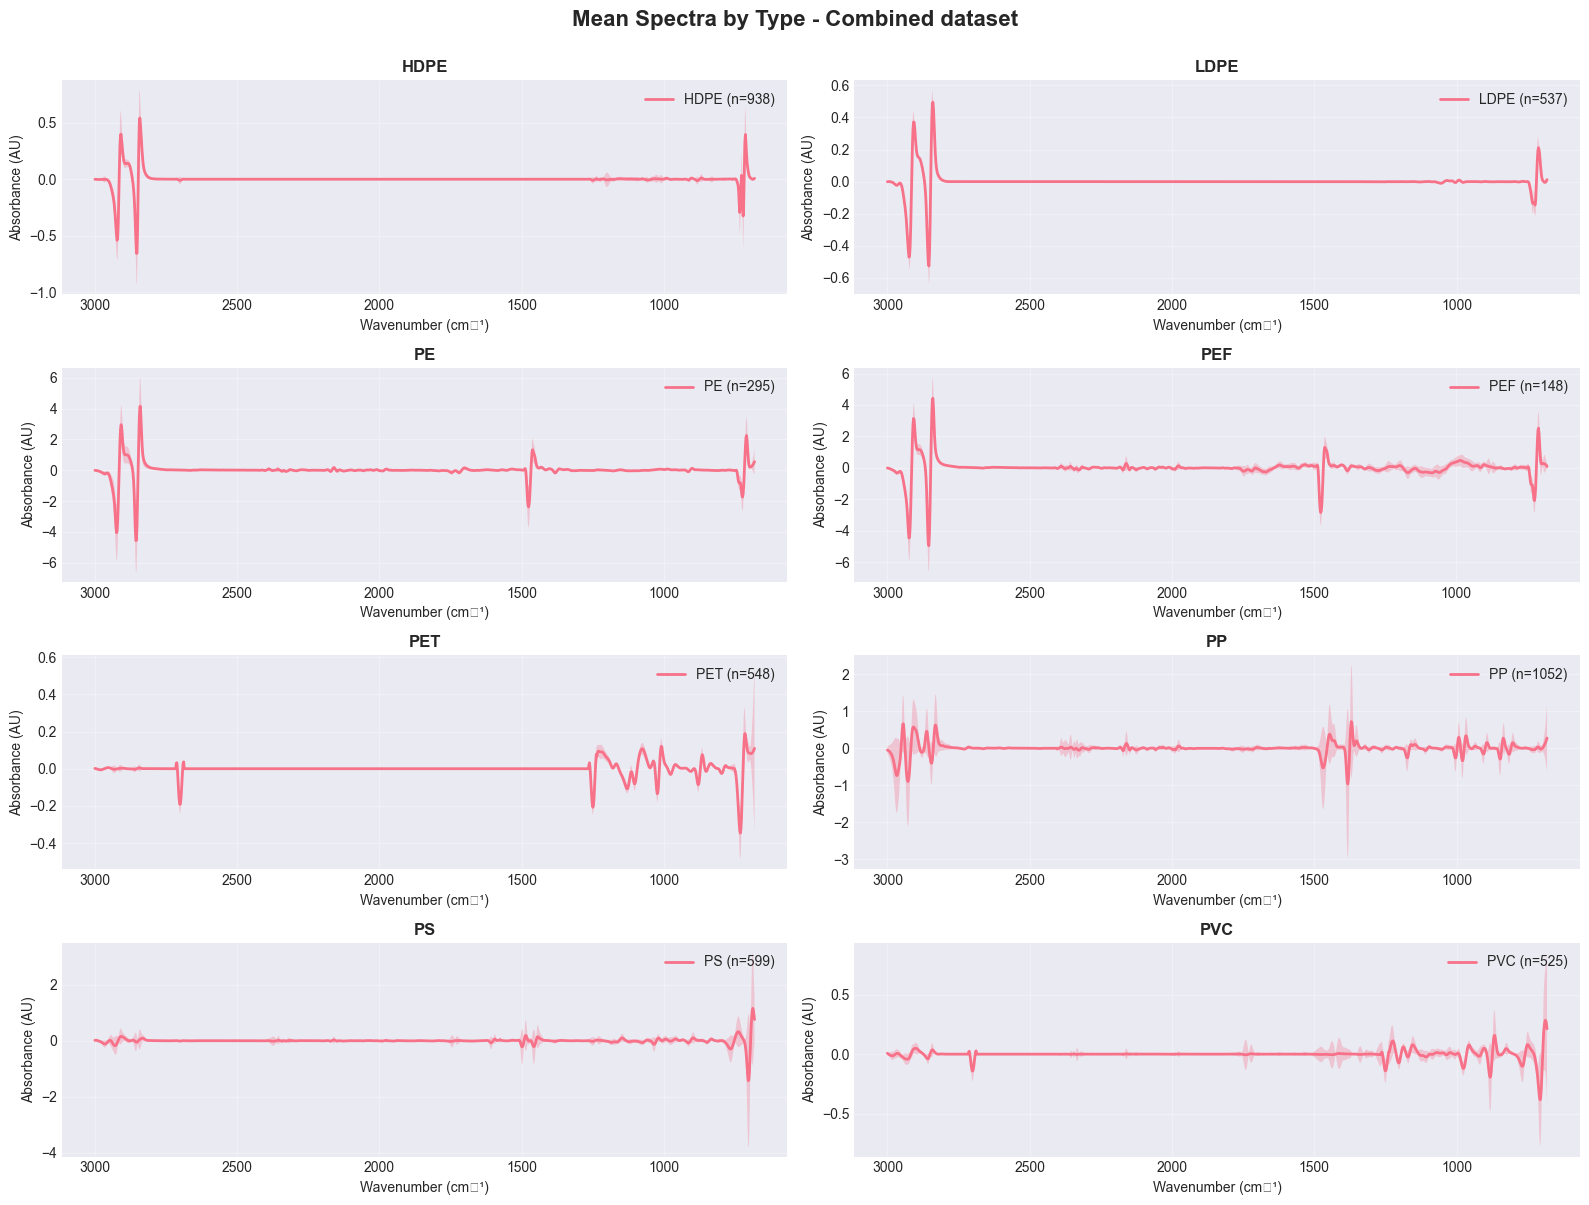

In [6]:
# Plot mean spectra for each polymer type in separate subplots
# This shows the characteristic spectral pattern for each polymer
fda.plot_mean_spectra(
    title="Mean Spectra by Type",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 4.2 Overlay Mean Spectra

Plot all mean spectra overlaid on the same axes for direct comparison. This helps identify spectral regions where polymers differ most.

Auto-detected: Absorbance


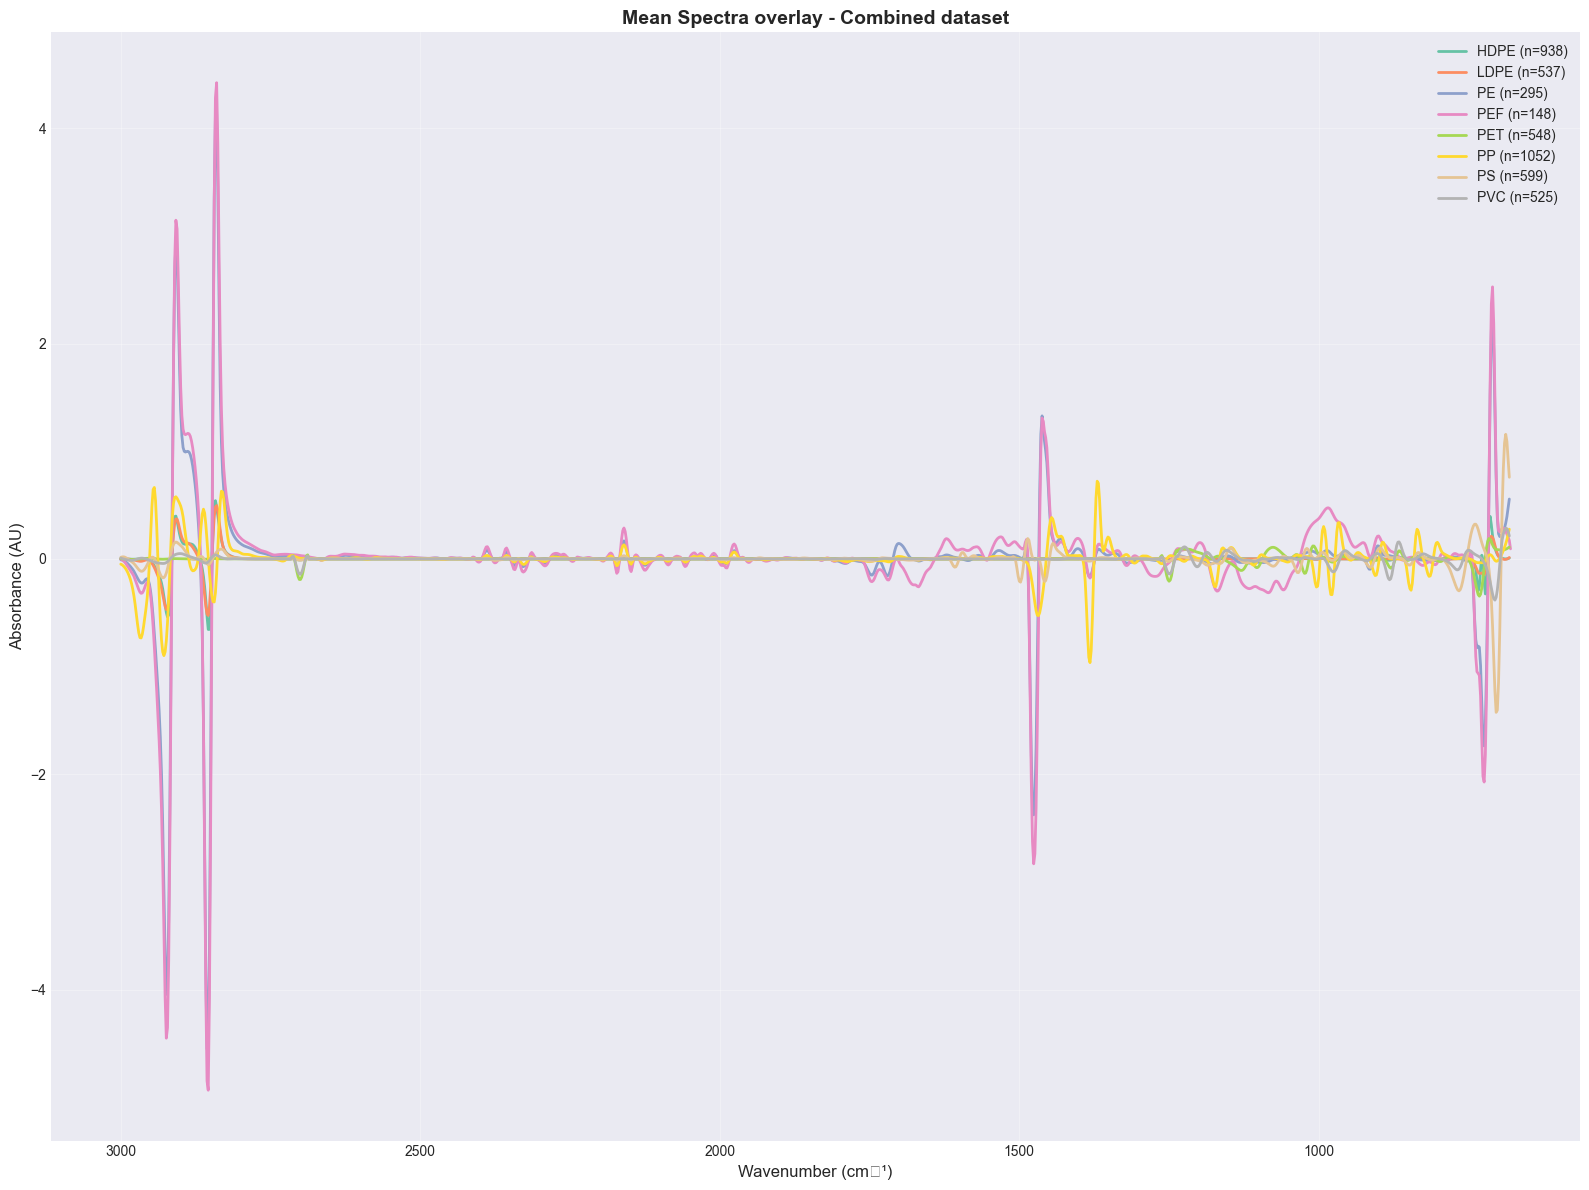

In [7]:
# Overlay all mean spectra on one plot for direct comparison
# Look for regions where spectra differ most - these are discriminative features
fda.plot_overlay_spectra(
    title="Mean Spectra overlay",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 4.3 Coefficient of Variation (CV) Plot

The CV plot shows spectral variability within each polymer type. High CV indicates regions with high within-group variability, which may be due to sample heterogeneity or measurement noise.

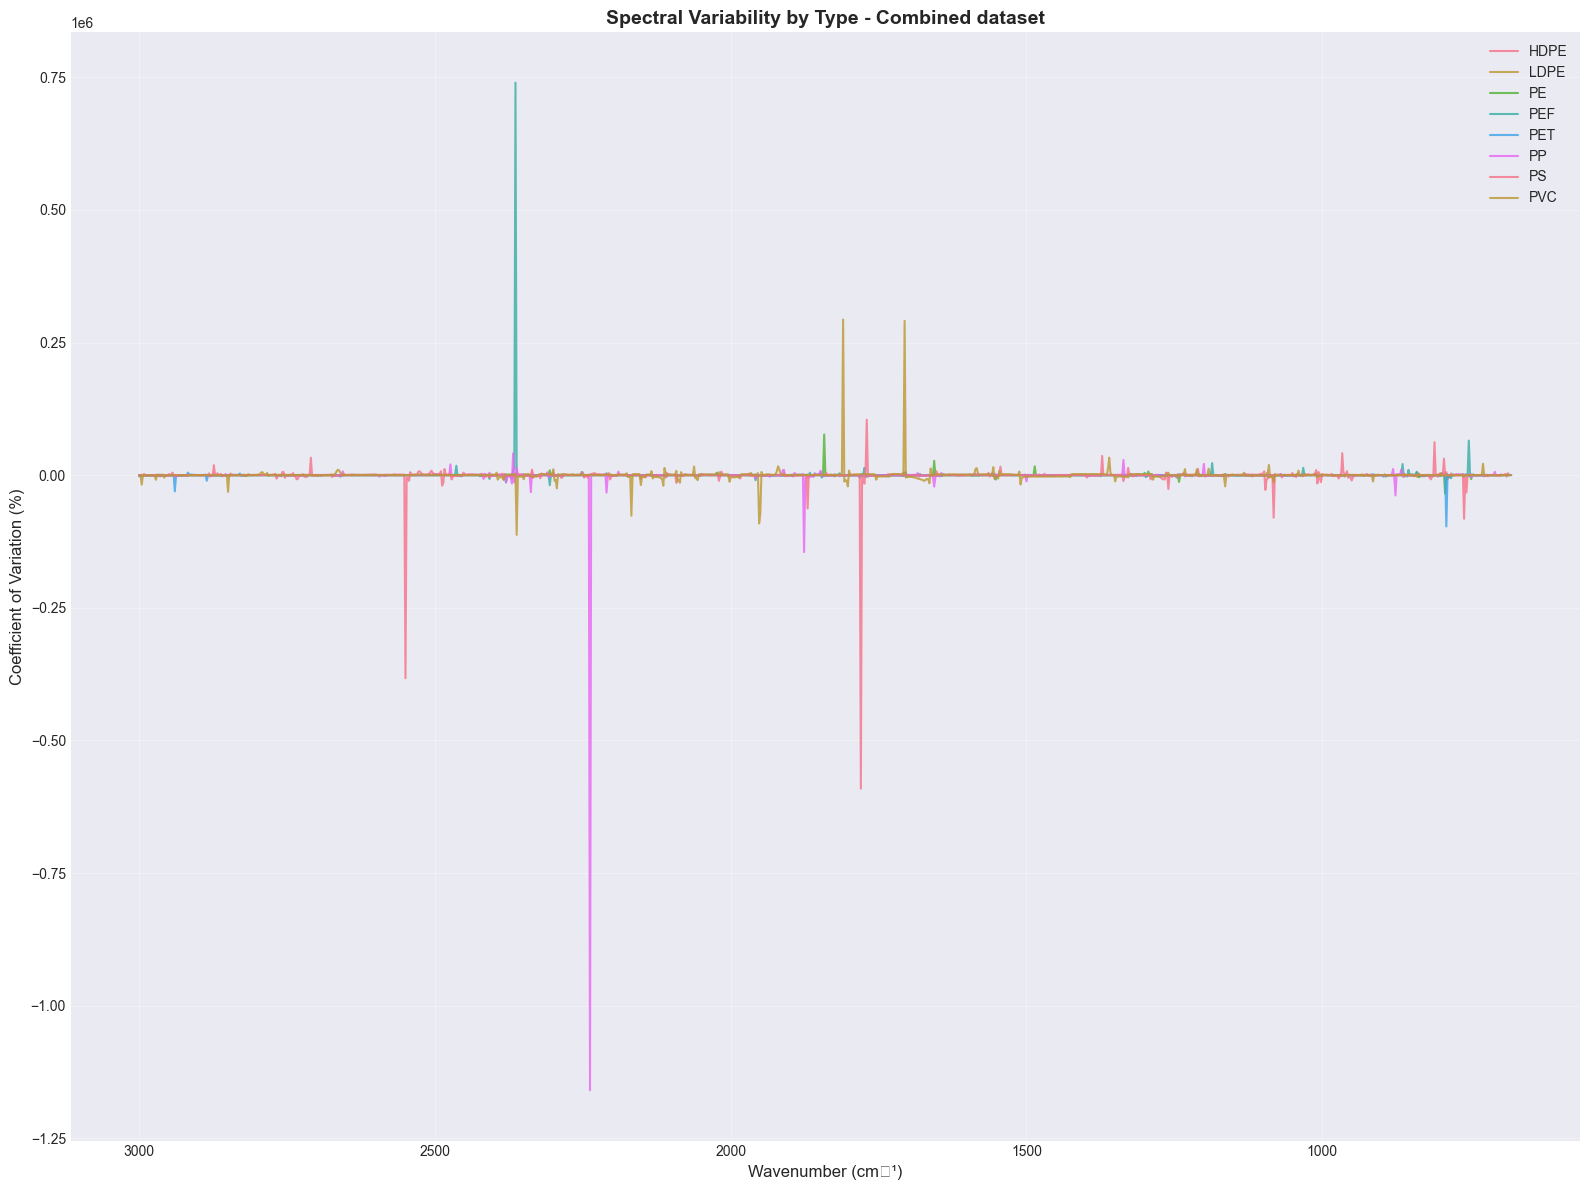

In [8]:
# Plot coefficient of variation (CV) to assess spectral variability
# Low CV = consistent spectra within polymer type
# High CV = high variability (may indicate sample heterogeneity)
fda.plot_cv(
    title="Spectral Variability by Type",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 4.4 Correlation Heatmap

Shows mean spectra for all polymer types as a heatmap. Brighter regions indicate higher absorbance, darker regions indicate lower absorbance.

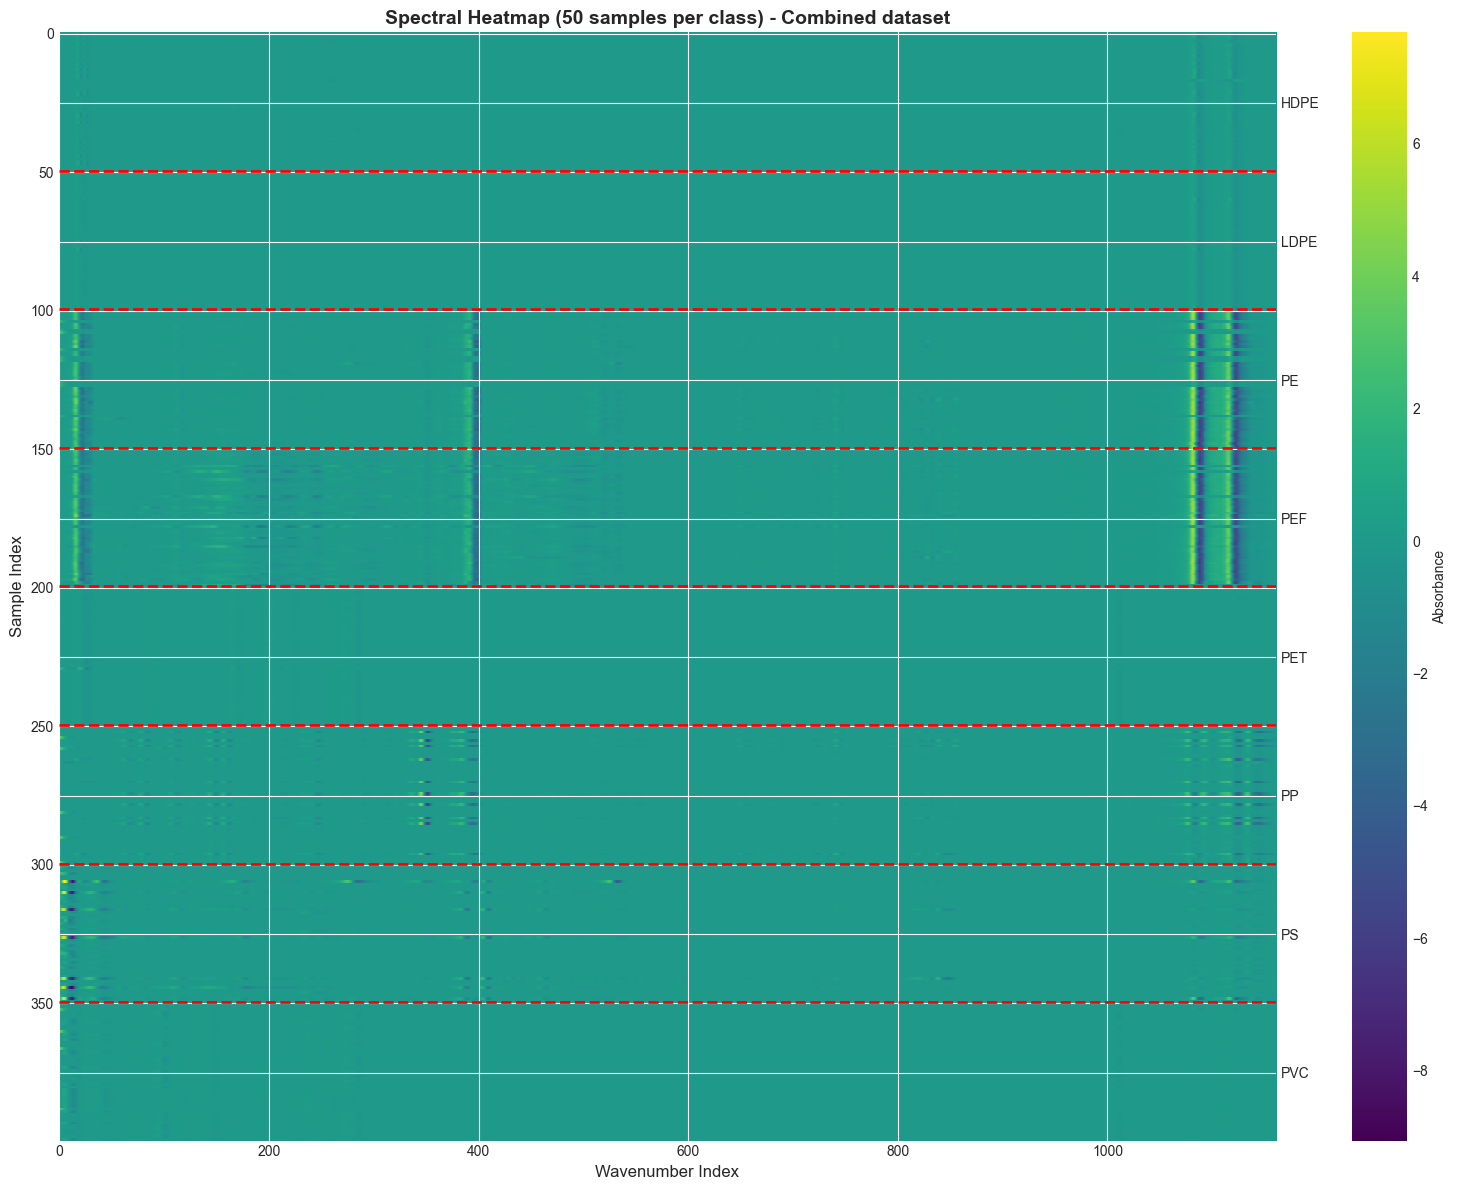

In [9]:
# Heatmap showing mean spectra for all polymer types
# Columns = wavenumbers, Rows = polymer types
# Color intensity = absorbance value
fda.plot_heatmap(
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

---

## Step 5: Statistical Analysis

### 5.1 ANOVA Analysis

Analysis of Variance (ANOVA) identifies wavenumbers where polymer types differ significantly. High F-values indicate discriminative features.

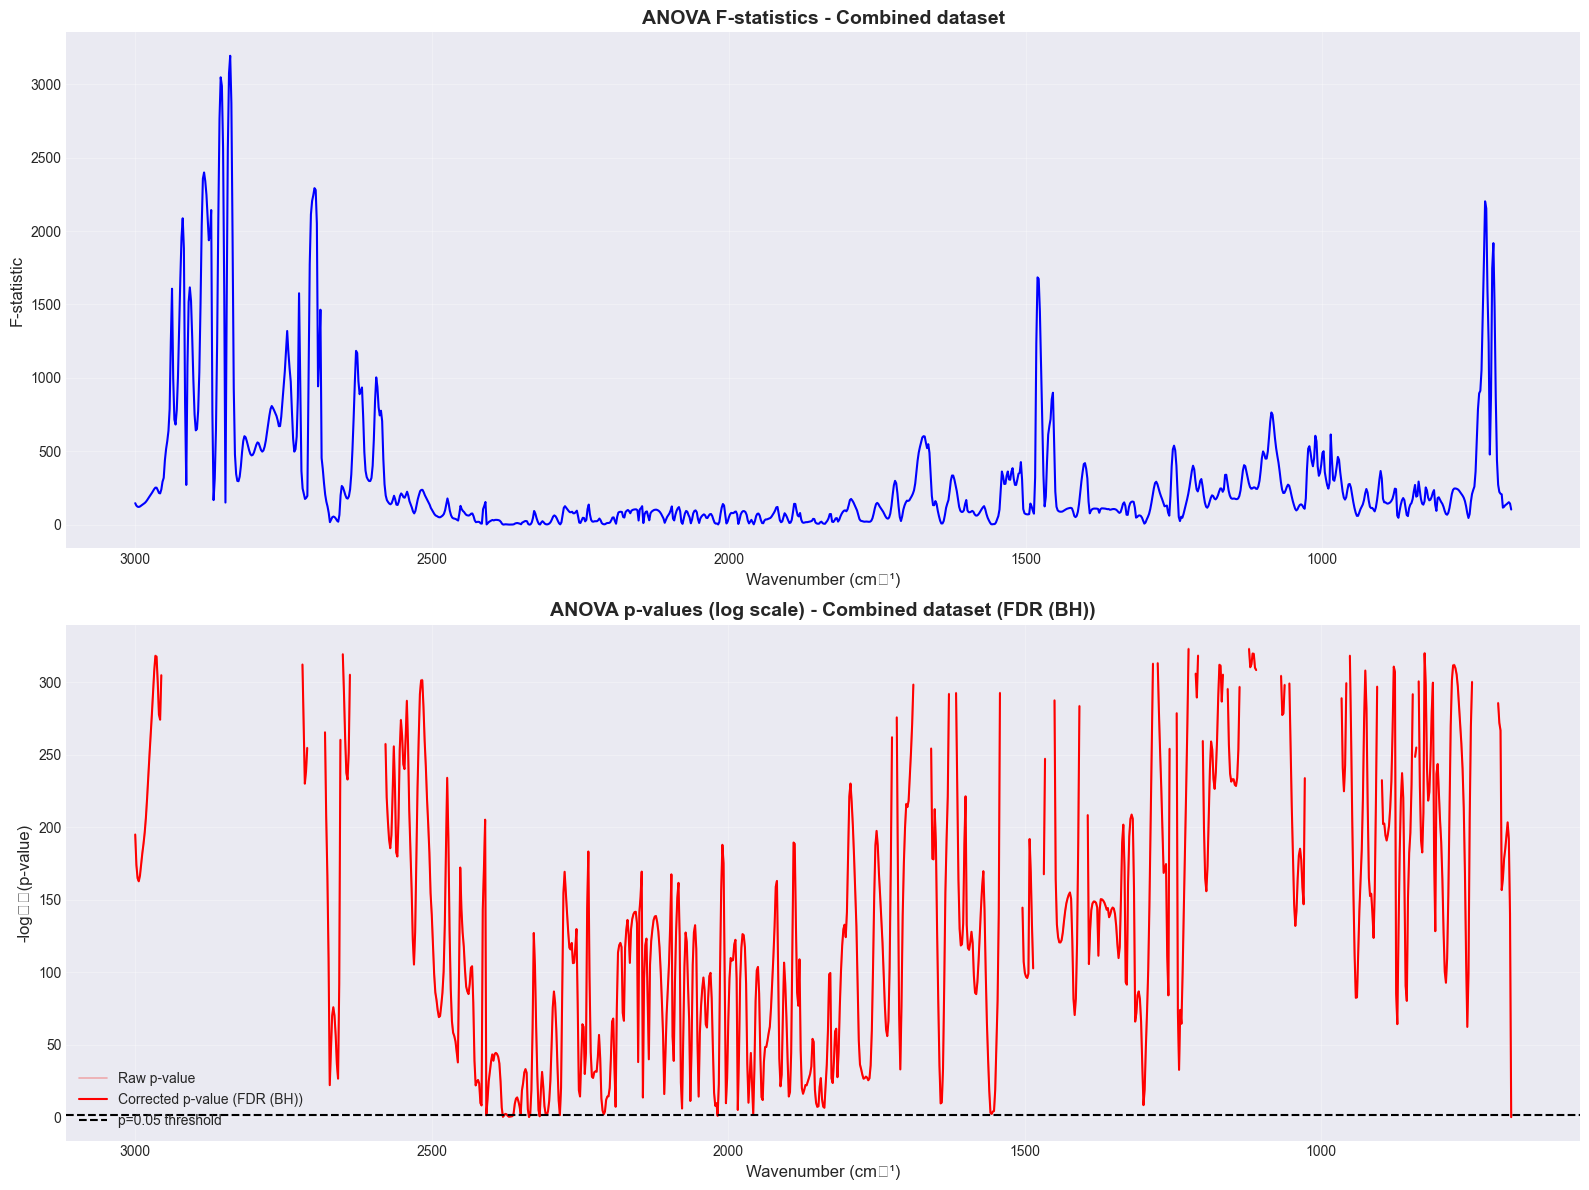


ANOVA Summary for Combined dataset:
  Total wavenumbers: 1161
  Mean F-statistic: nan
  Max F-statistic: nan at 680.0 cm⁻¹

  Multiple testing correction: FDR (BH)
  Significant features (raw p < 0.05): 1149 (99.0%)
  Significant features (corrected p < 0.05): 1149 (99.0%)


{'wavenumbers': array([ 680.,  682.,  684., ..., 2996., 2998., 3000.], shape=(1161,)),
 'f_statistics': array([         nan, 103.37967212, 144.12272326, ..., 122.51786474,
        129.71572475, 146.50765582], shape=(1161,)),
 'p_values': array([1.00000000e+000, 5.08259267e-141, 6.62224671e-193, ...,
        1.02628766e-165, 7.46396754e-175, 7.29345762e-196], shape=(1161,)),
 'p_values_corrected': array([1.00000000e+000, 8.47829035e-141, 1.39535906e-192, ...,
        1.92802584e-165, 1.44910808e-174, 1.55656329e-195], shape=(1161,)),
 'significant': array([False,  True,  True, ...,  True,  True,  True], shape=(1161,))}

In [10]:
# Perform ANOVA to identify discriminative wavenumbers
# High F-values = large between-group variance relative to within-group variance
# These wavenumbers are most useful for classification
fda.perform_anova(
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 5.2 Correlation Analysis

Examines correlations between wavenumbers. Highly correlated features provide redundant information.

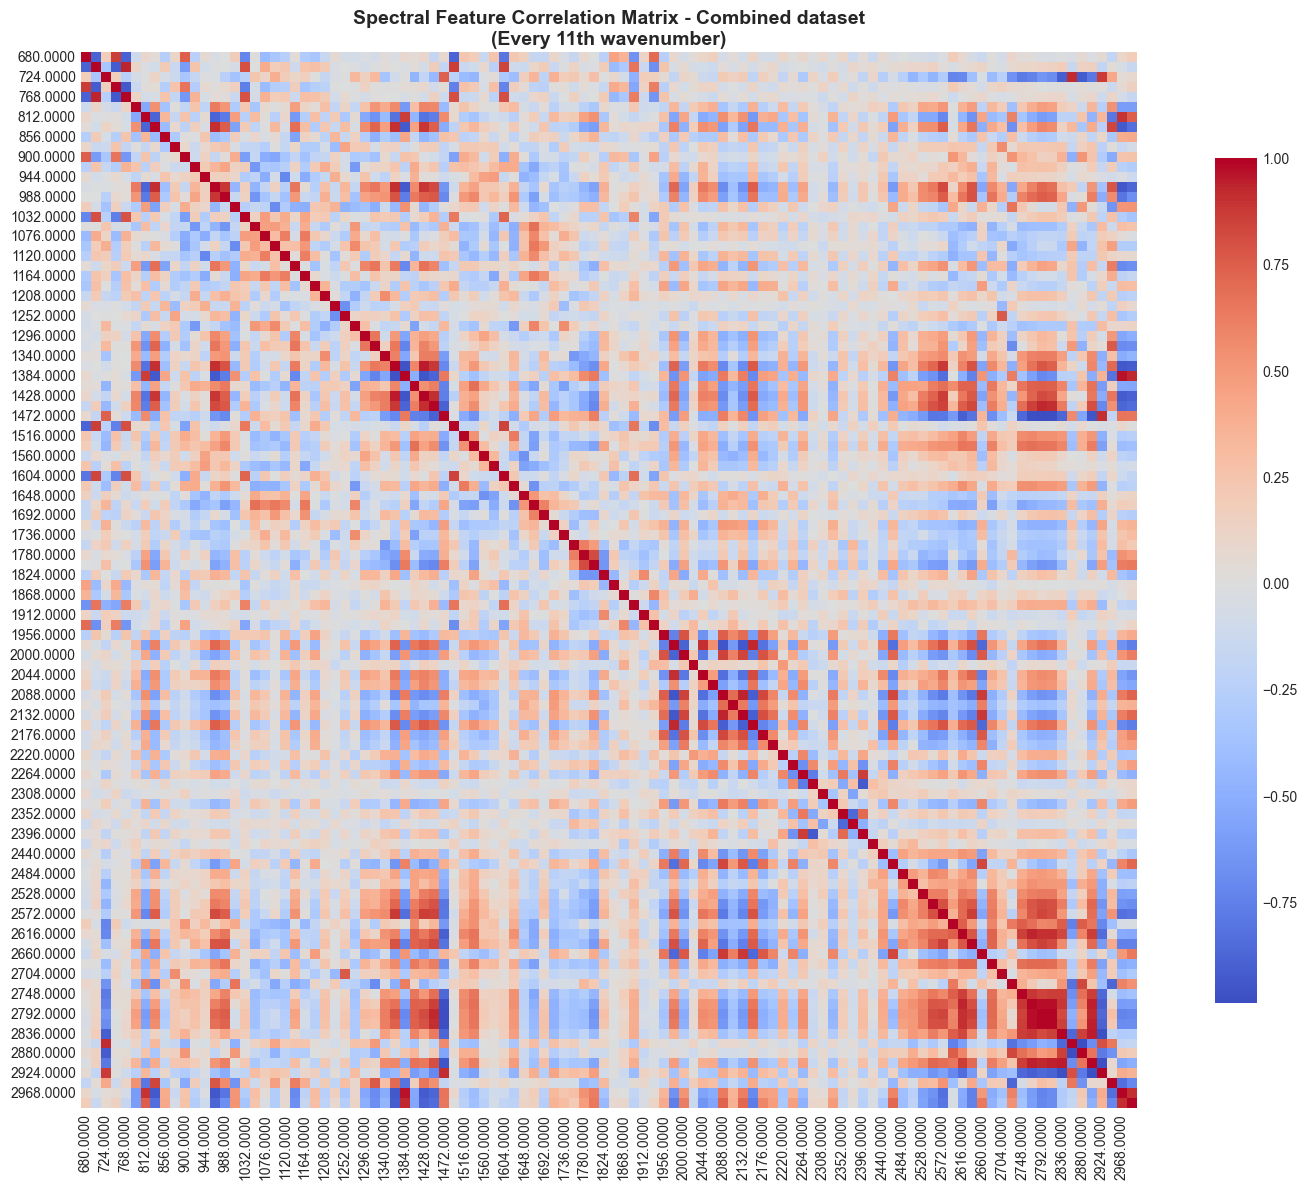


Correlation Summary for Combined dataset:
  Mean correlation: 0.013
  Max correlation: 0.993
  Min correlation: -0.988


In [11]:
# Correlation analysis between wavenumbers
# Dark red/blue = highly correlated features (redundant information)
# White = uncorrelated features (independent information)
fda.plot_correlation(
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

---

## Step 6: Dimensionality Reduction

High-dimensional spectral data (1000+ features) can be reduced to 2-3 dimensions for visualization while preserving important patterns.

### 6.1 Principal Component Analysis (PCA)

PCA finds linear combinations of features that explain maximum variance. PC1 and PC2 typically capture the most important spectral variations.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)


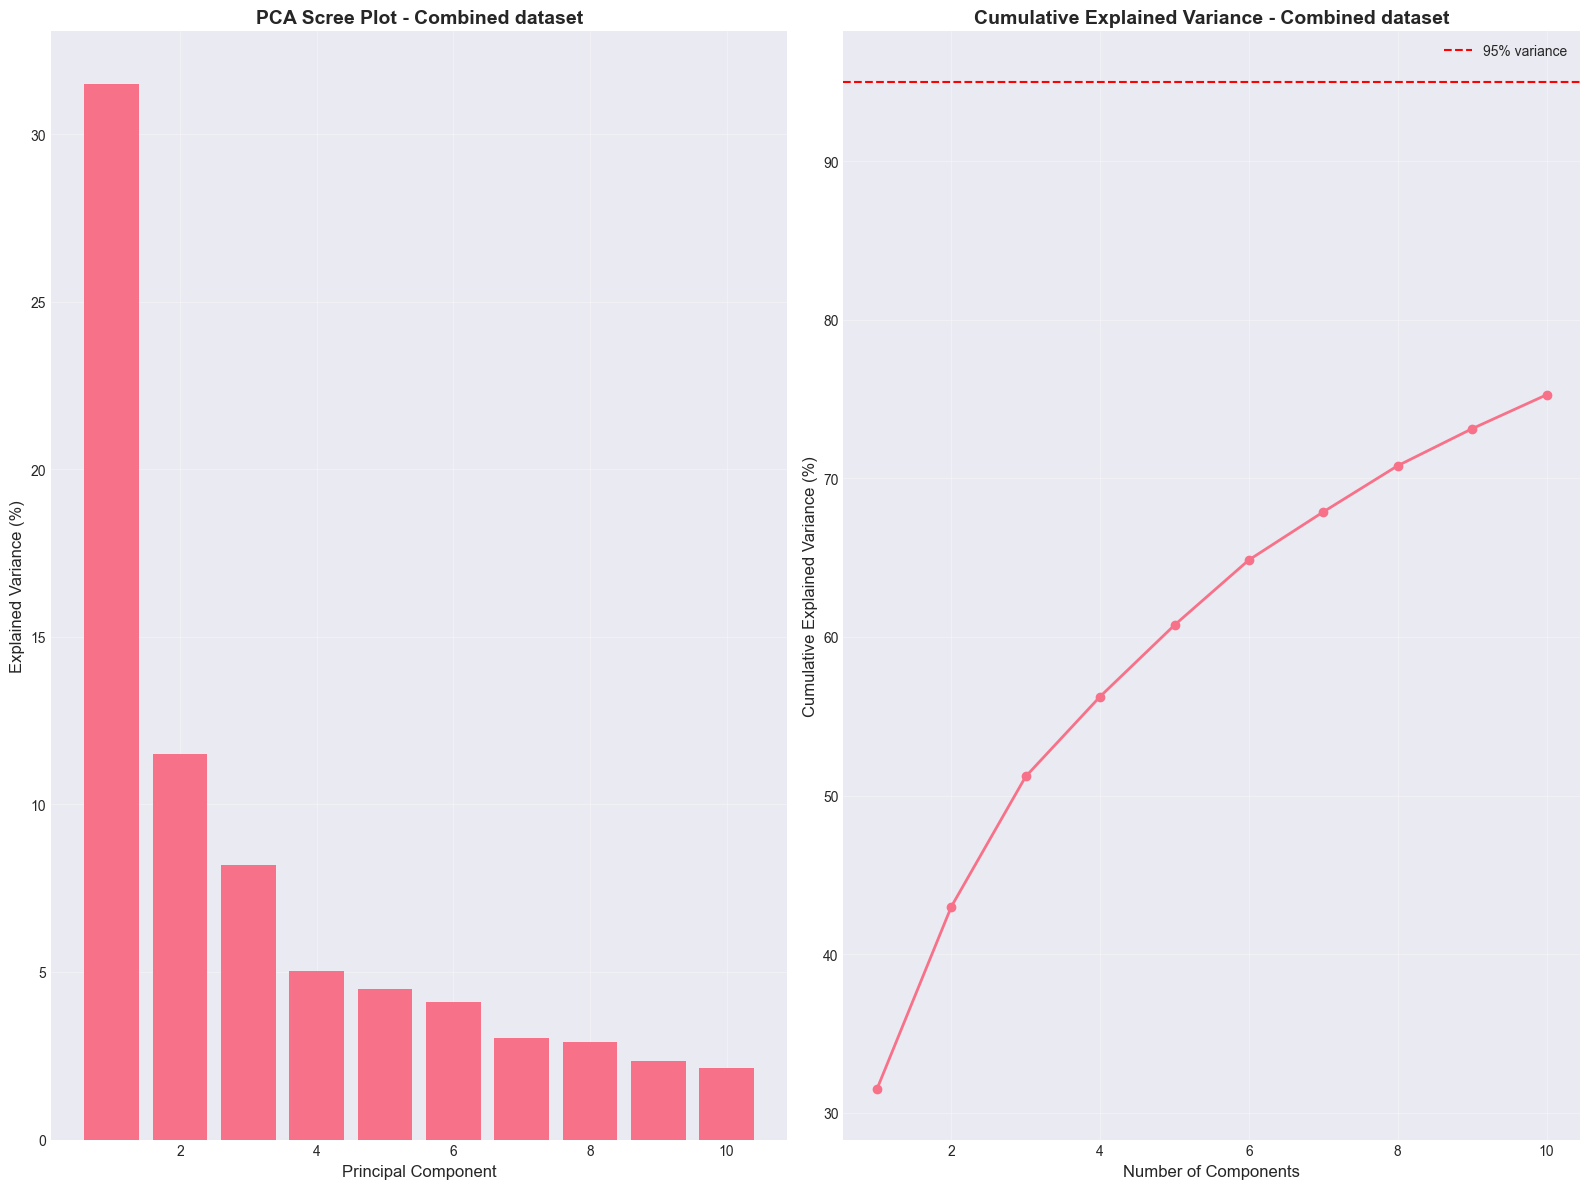


PCA Summary for Combined dataset:
  PC1 explains: 31.50%
  PC2 explains: 11.50%
  First 2 PCs explain: 43.00%
  First 3 PCs explain: 51.21%
  Components needed for 95% variance: 1


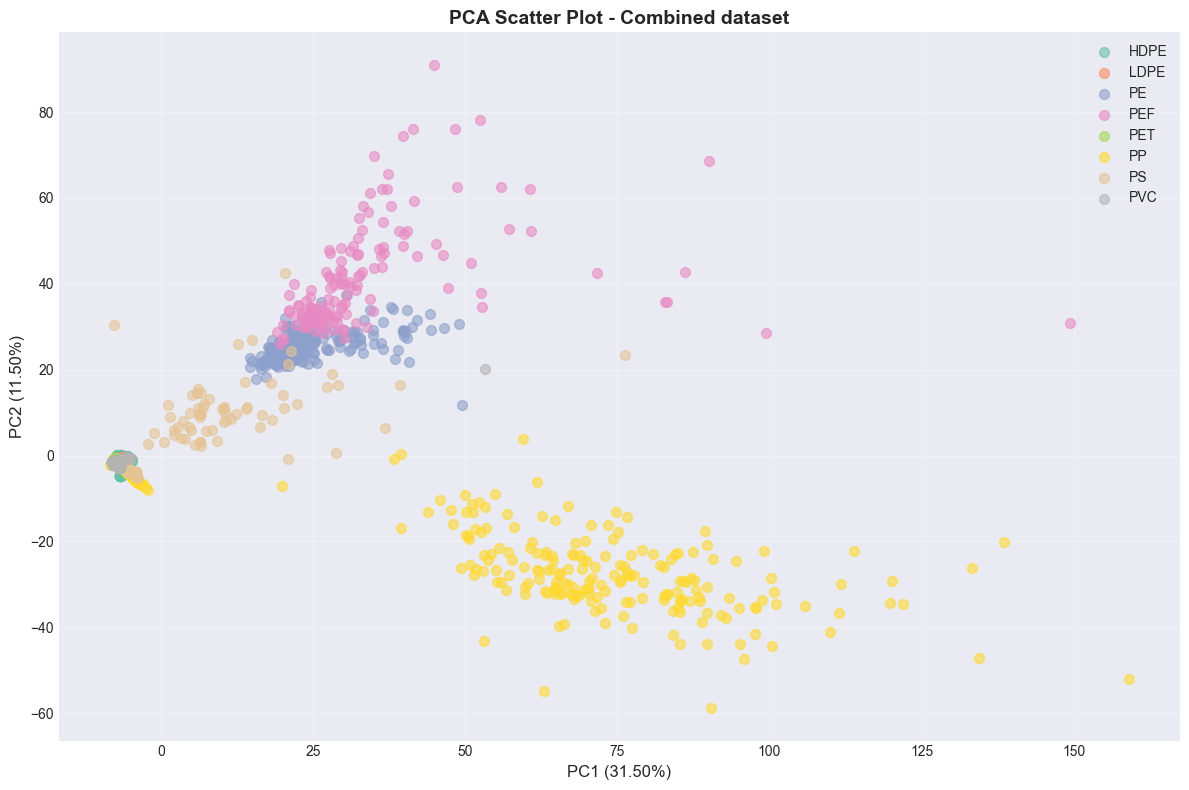

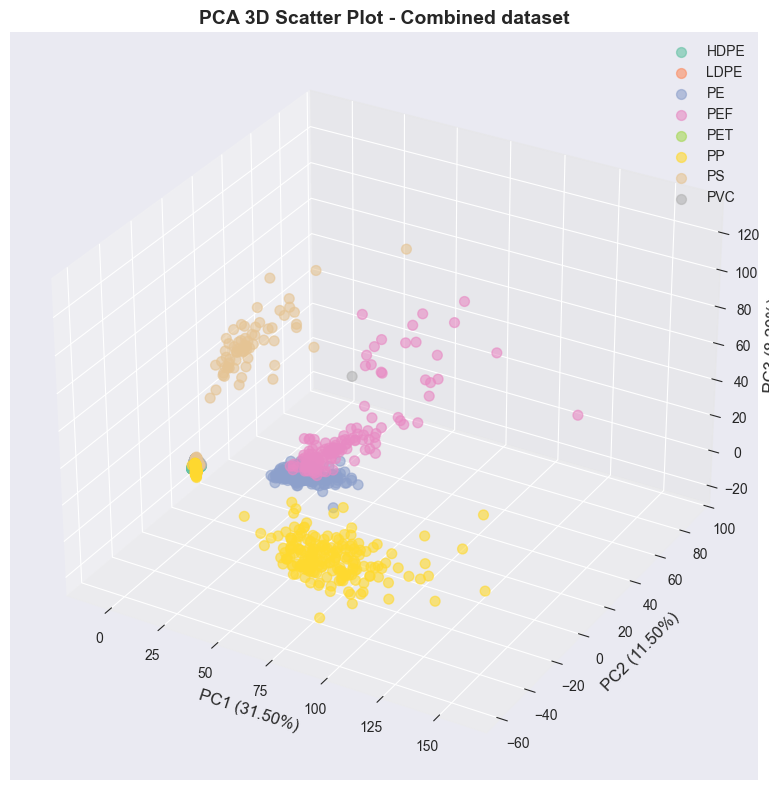

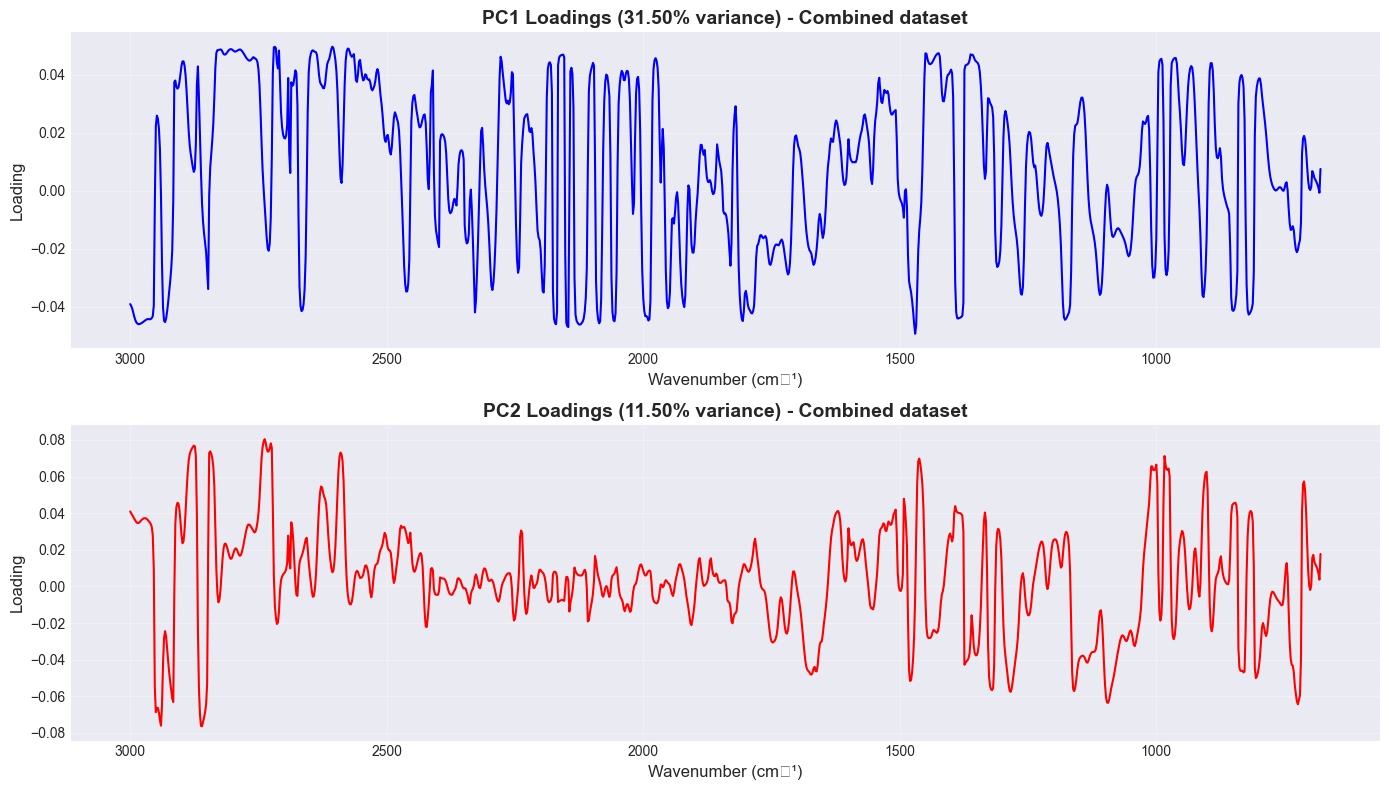

In [12]:
# PCA: Linear dimensionality reduction
# standardize=True: Standardize features before PCA
# handle_missing="zero": Replace any NaN values with 0
# Look for:
#   - Clear separation between polymer types
#   - Explained variance in PC1 and PC2
#   - Outliers
fda.plot_pca(
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 6.2 t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE preserves local structure better than PCA, often revealing clusters not visible in PCA. Good for visualizing natural groupings.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)
Performing t-SNE for Combined dataset...
  Using 20 PCA components as input
  Perplexity: 50
  Iterations: 1000
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4642 samples in 0.000s...
[t-SNE] Computed neighbors for 4642 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4642
[t-SNE] Computed conditional probabilities for sample 2000 / 4642
[t-SNE] Computed conditional probabilities for sample 3000 / 4642
[t-SNE] Computed conditional probabilities for sample 4000 / 4642
[t-SNE] Computed conditional probabilities for sample 4642 / 4642
[t-SNE] Mean sigma: 0.087689
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.368515
[t-SNE] KL divergence after 1000 iterations: 0.317555


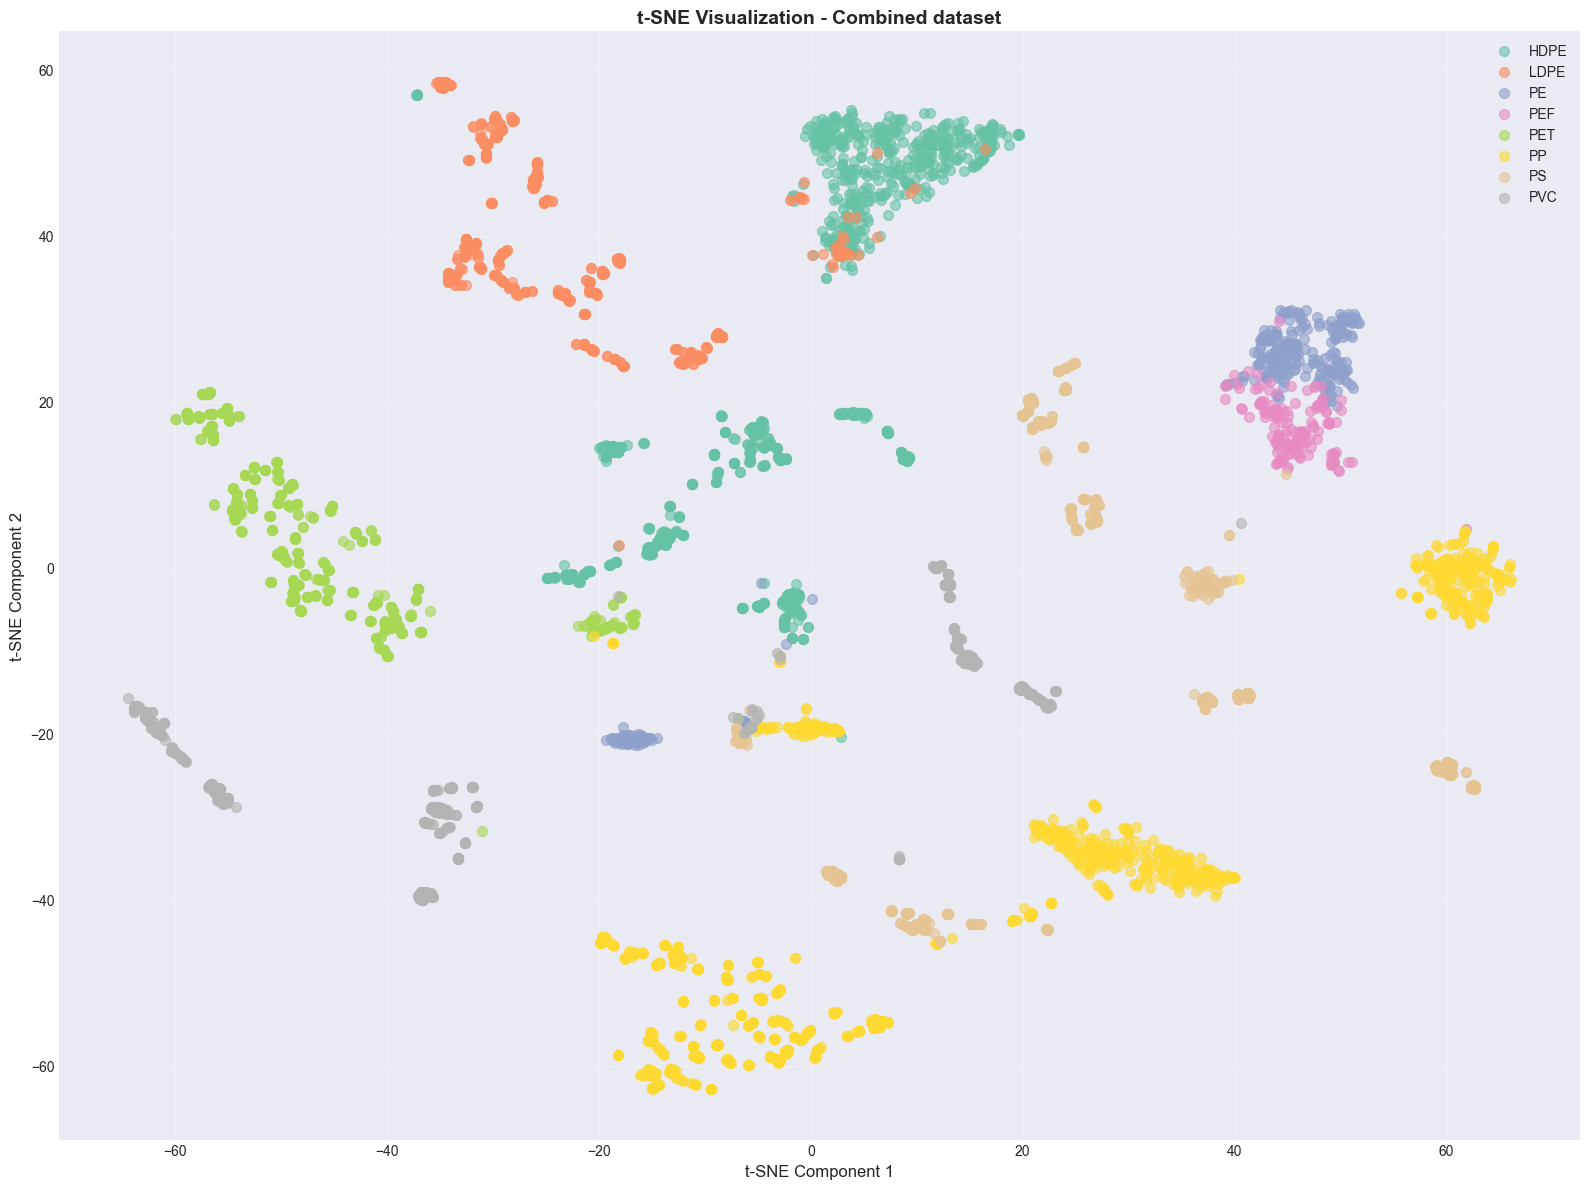

In [13]:
# t-SNE: Non-linear dimensionality reduction
# perplexity=50: Balance between local and global structure (5-50 typical)
# n_iter=1000: Number of optimization iterations
# pca_components=20: Pre-reduce to 20 dimensions with PCA (faster, often better)
# Look for:
#   - Tight clusters of same polymer type
#   - Separation between different types
#   - Mixed clusters may indicate similar polymers
fda.plot_tsne(
    perplexity=50,
    n_iter=1000,
    pca_components=20,
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 6.3 UMAP (Uniform Manifold Approximation and Projection)

UMAP is faster than t-SNE and often preserves both local and global structure better. Excellent for large datasets.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)
Performing UMAP for Combined dataset...
  Using 20 PCA components as input
  n_neighbors: 100
  min_dist: 0.5
UMAP(min_dist=0.5, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Sat Jan 10 19:33:13 2026 Construct fuzzy simplicial set
Sat Jan 10 19:33:13 2026 Finding Nearest Neighbors
Sat Jan 10 19:33:13 2026 Building RP forest with 8 trees
Sat Jan 10 19:33:15 2026 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Sat Jan 10 19:33:19 2026 Finished Nearest Neighbor Search
Sat Jan 10 19:33:20 2026 Construct embedding


Epochs completed:   2%| ▏          10/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  12%| █▏         62/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  22%| ██▏        110/500 [00:03]

	completed  100  /  500 epochs


Epochs completed:  32%| ███▏       162/500 [00:04]

	completed  150  /  500 epochs


Epochs completed:  41%| ████       206/500 [00:05]

	completed  200  /  500 epochs


Epochs completed:  52%| █████▏     258/500 [00:07]

	completed  250  /  500 epochs


Epochs completed:  62%| ██████▏    310/500 [00:08]

	completed  300  /  500 epochs


Epochs completed:  72%| ███████▏   362/500 [00:09]

	completed  350  /  500 epochs


Epochs completed:  82%| ████████▏  410/500 [00:11]

	completed  400  /  500 epochs


Epochs completed:  92%| █████████▏ 462/500 [00:12]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:13]


Sat Jan 10 19:33:34 2026 Finished embedding


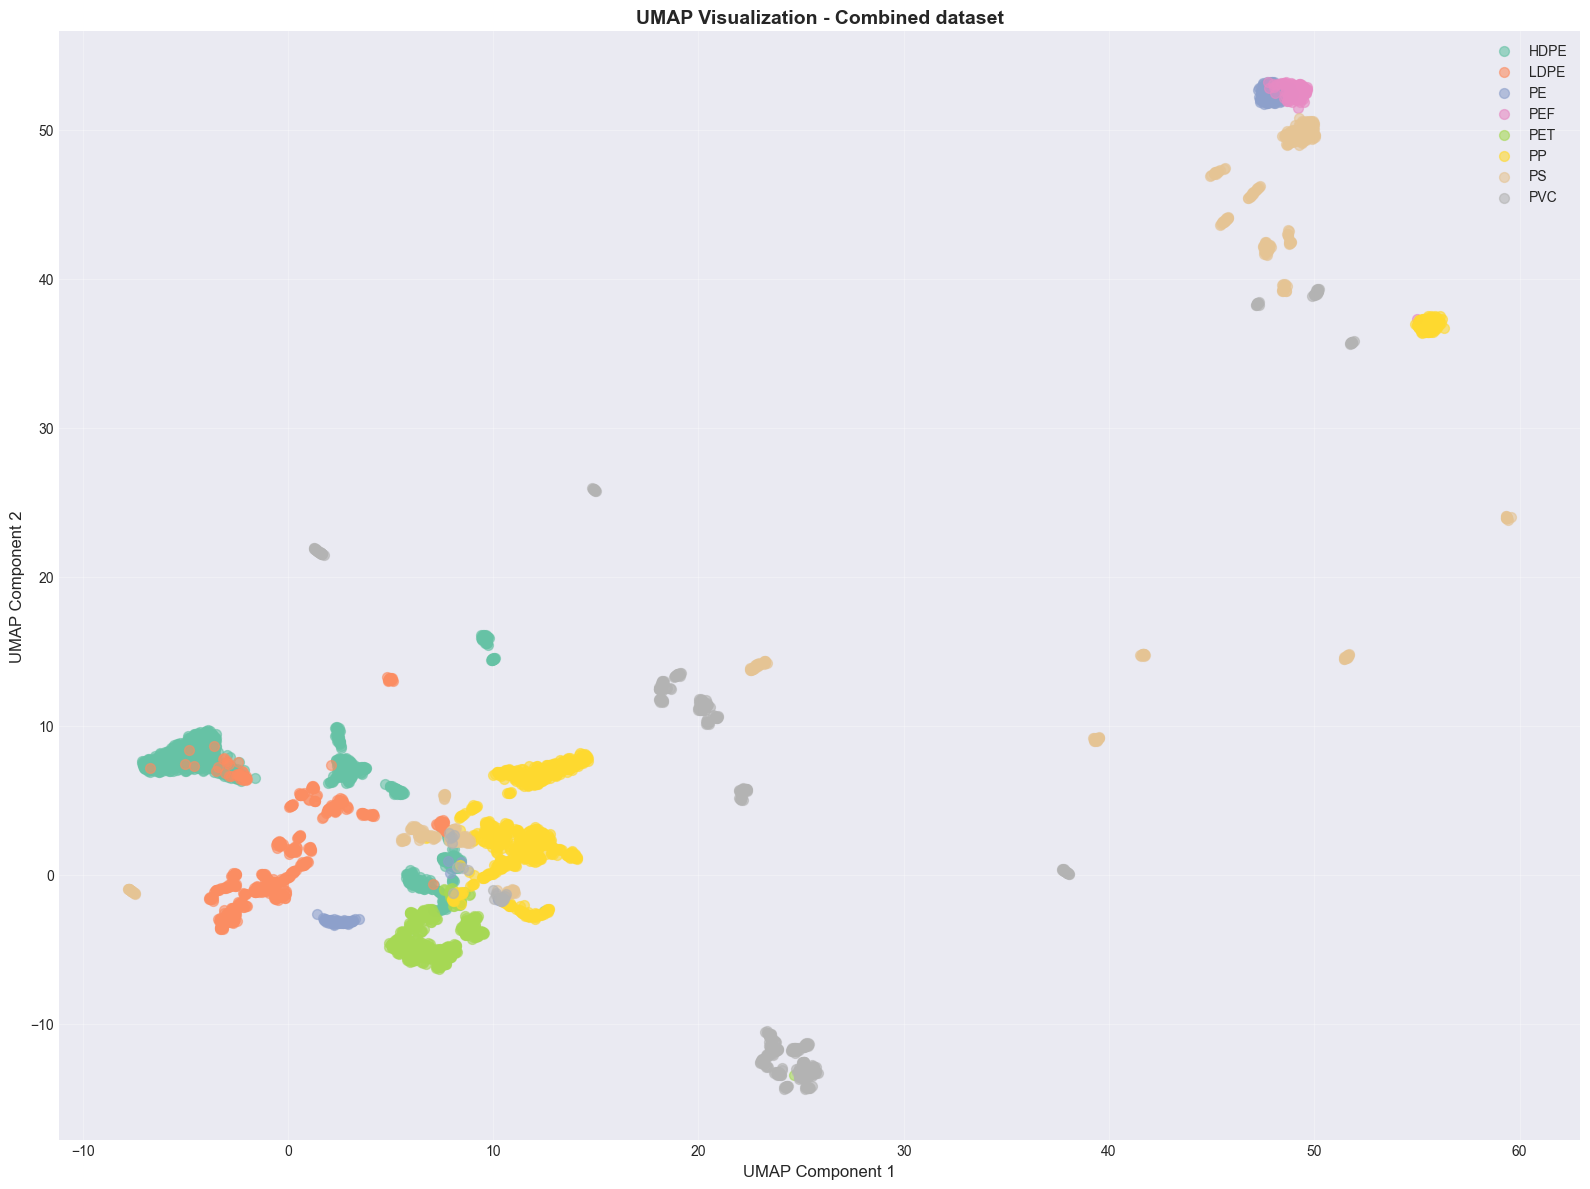

In [14]:
# UMAP: Modern non-linear dimensionality reduction
# n_neighbors=100: Size of local neighborhood (2-200 typical)
# min_dist=0.5: Minimum distance between points in embedding (0.0-0.99)
# pca_components=20: Pre-reduce dimensionality
# Look for:
#   - Balance of local and global structure
#   - Clear polymer type clusters
#   - Overall topology of the data
fda.plot_umap(
    n_neighbors=100,
    min_dist=0.5,
    pca_components=20,
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 6.4 PLS-DA (Partial Least Squares Discriminant Analysis)

PLS-DA is a supervised method that finds components maximizing separation between classes. Better than PCA for classification.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)
Performing PLS-DA for Combined dataset...
  Number of classes: 8
  Number of components: 20
  R²X (variance explained in X): 0.6562
  R²Y (variance explained in Y): 0.3883


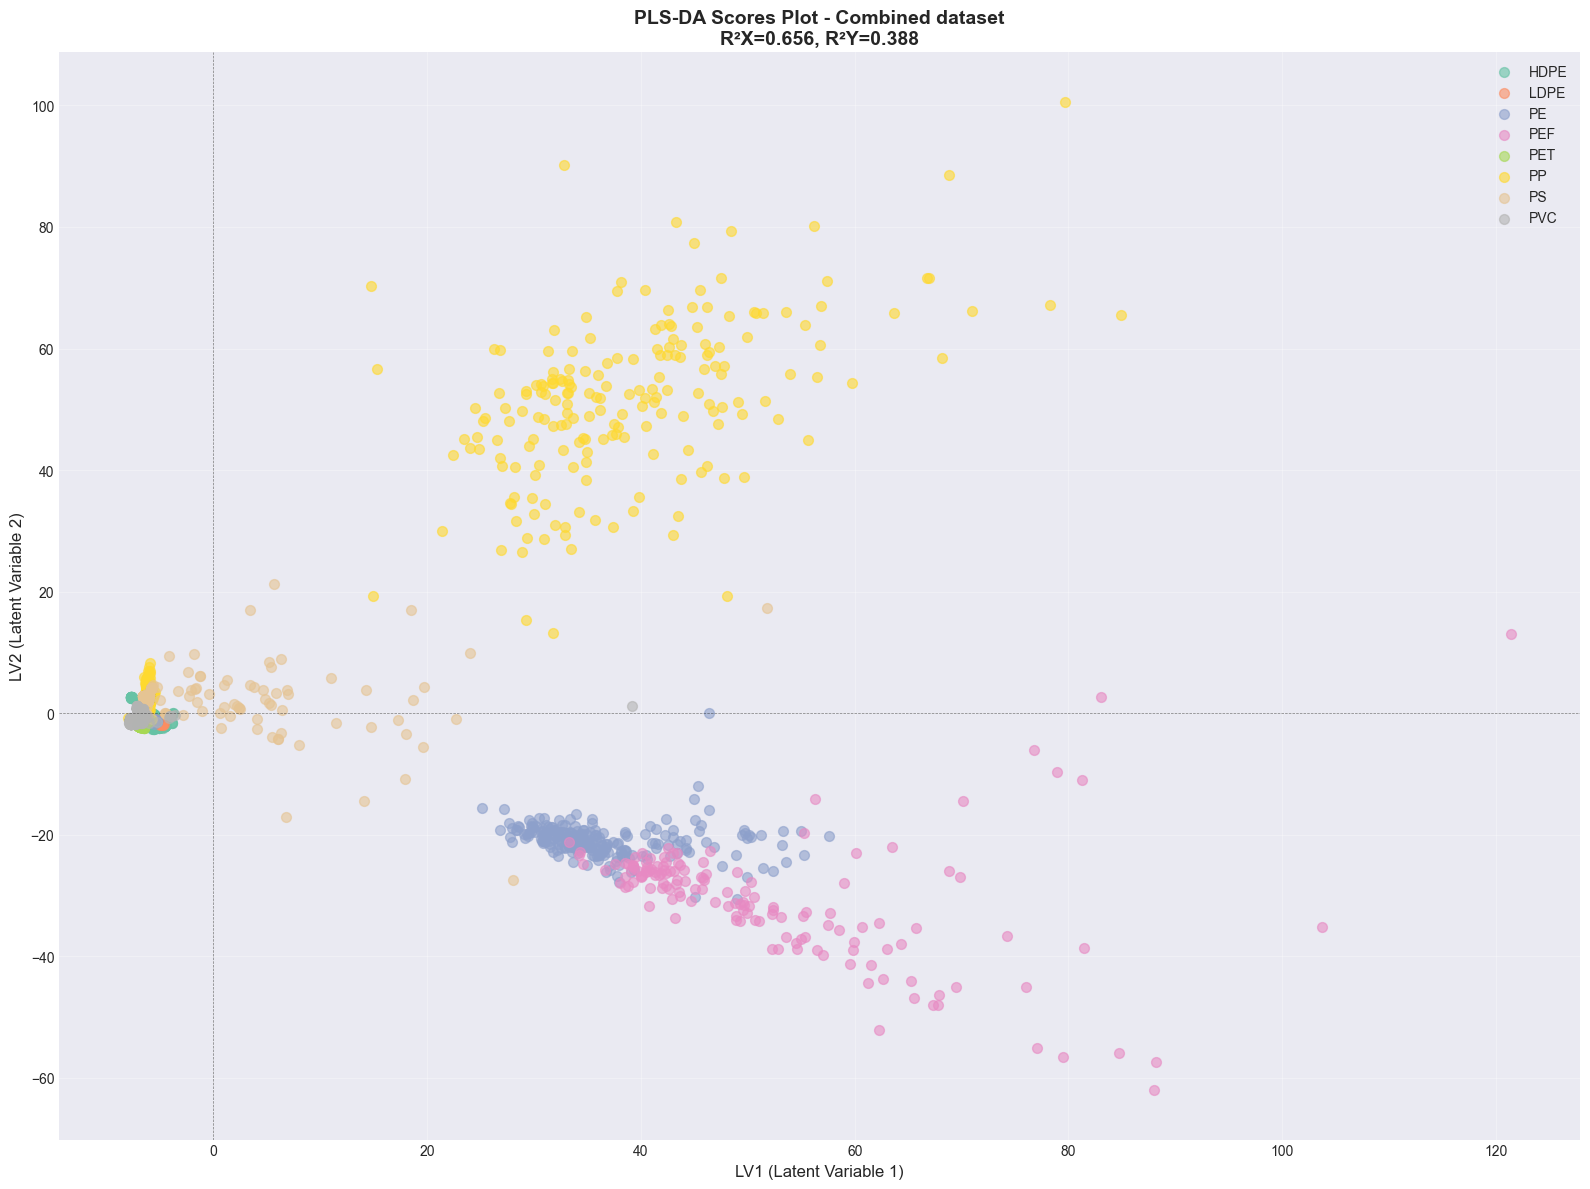

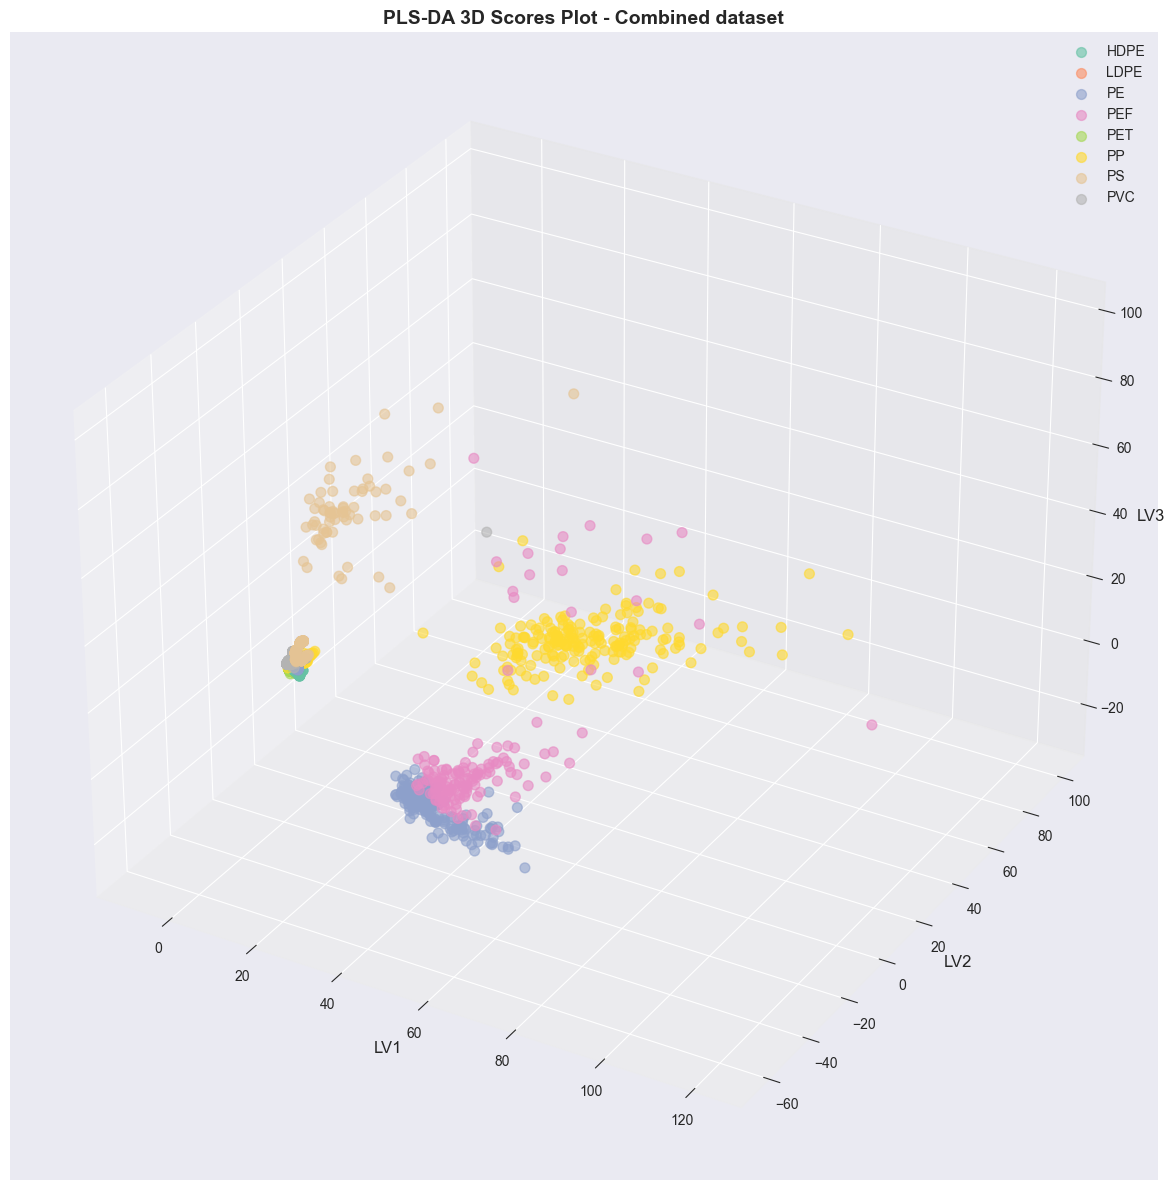

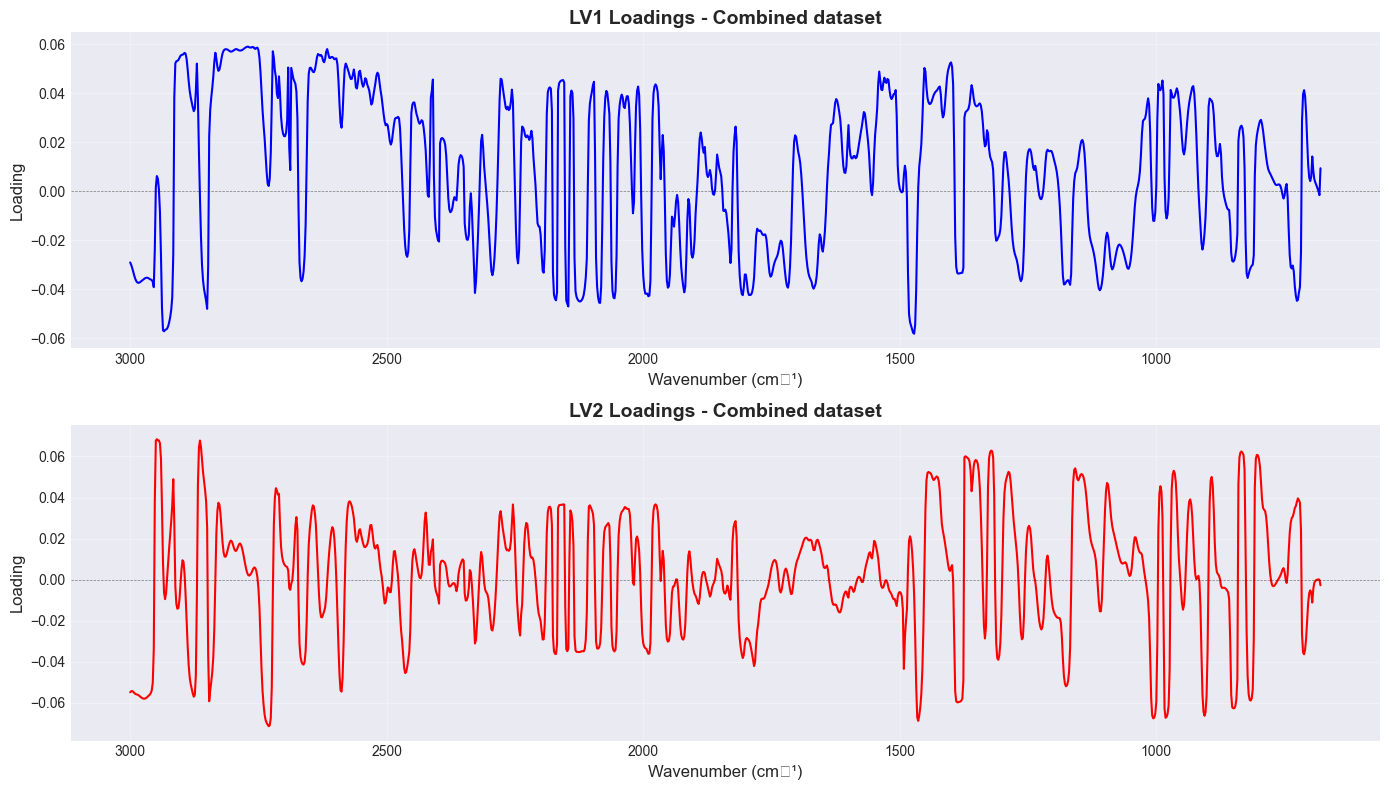

In [15]:
# PLS-DA: Supervised dimensionality reduction for classification
# n_components=20: Number of PLS components to extract
# This method uses class labels to find components that maximize separation
fda.plot_plsda(
    n_components=20,
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 6.5 OPLS-DA (Orthogonal PLS-DA)

OPLS-DA separates variation related to class separation from orthogonal variation (noise). Better interpretability than PLS-DA.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)
Performing OPLS-DA for Combined dataset...
  Number of classes: 8
  Predictive components: 1
  Orthogonal components: 2
  R²X (variance explained in X): 0.4563
  R²Y (variance explained in Y): -0.1415


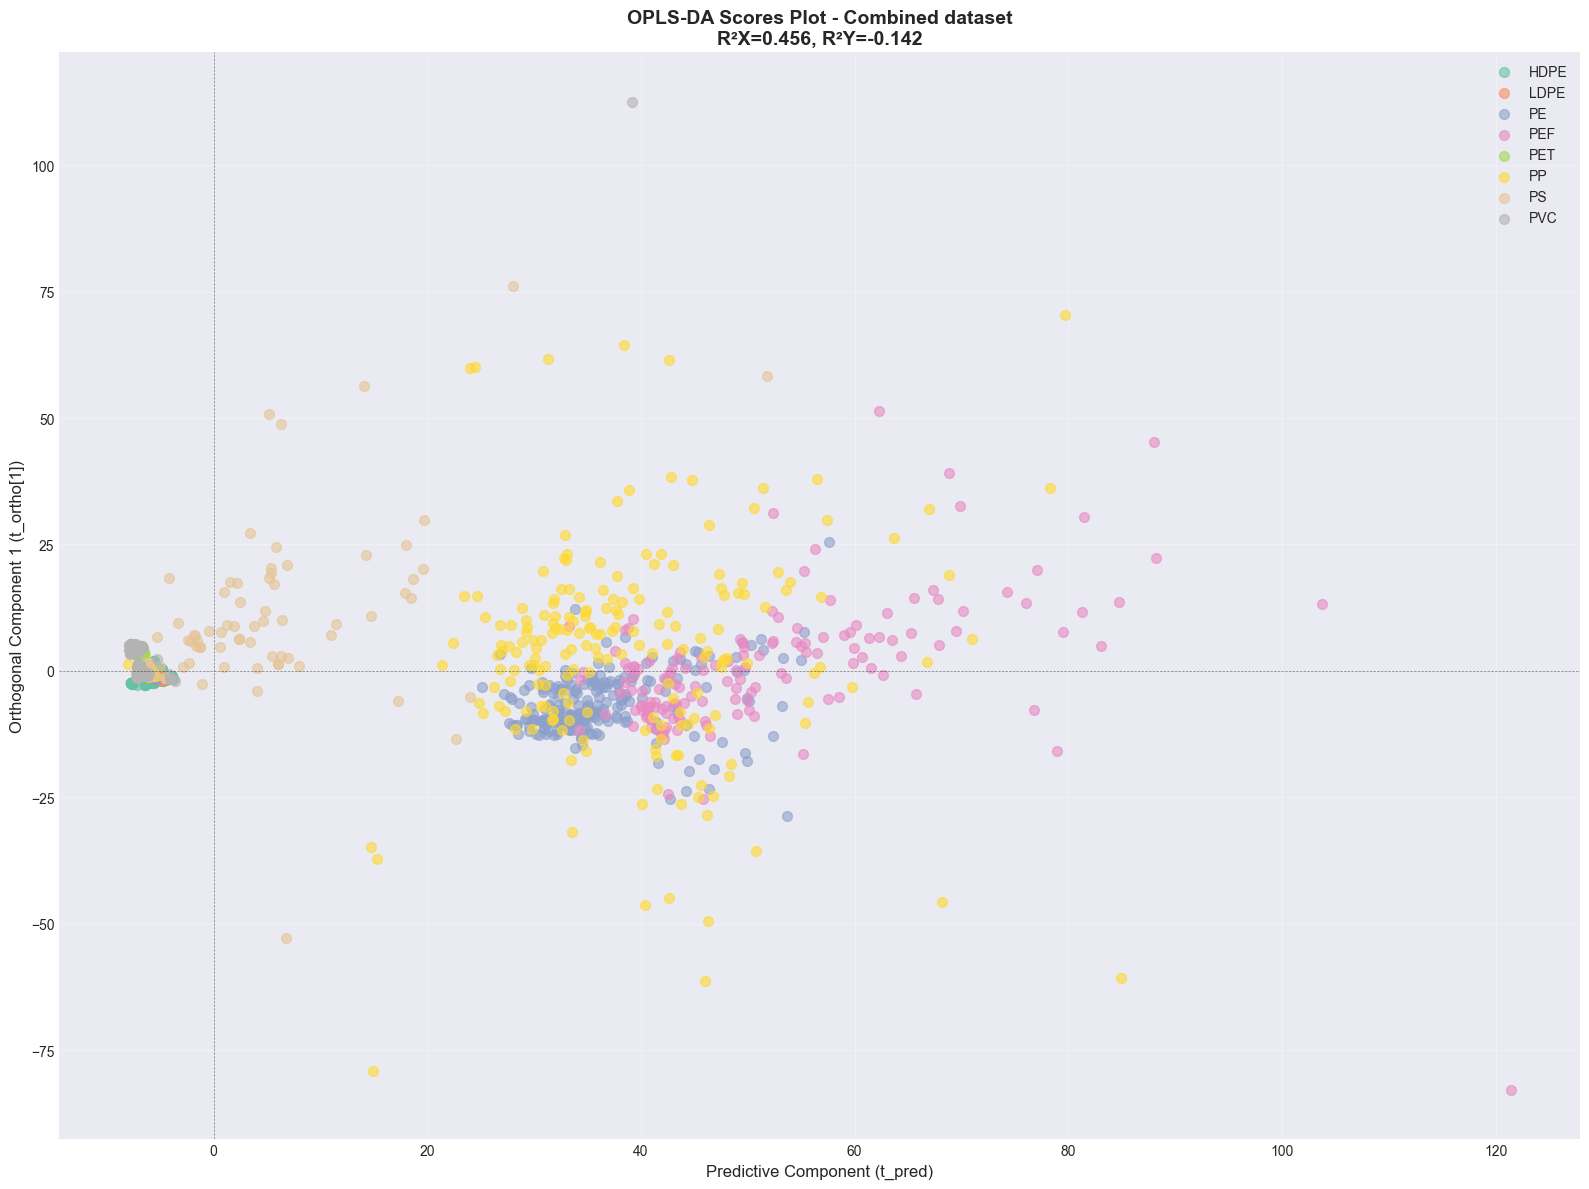

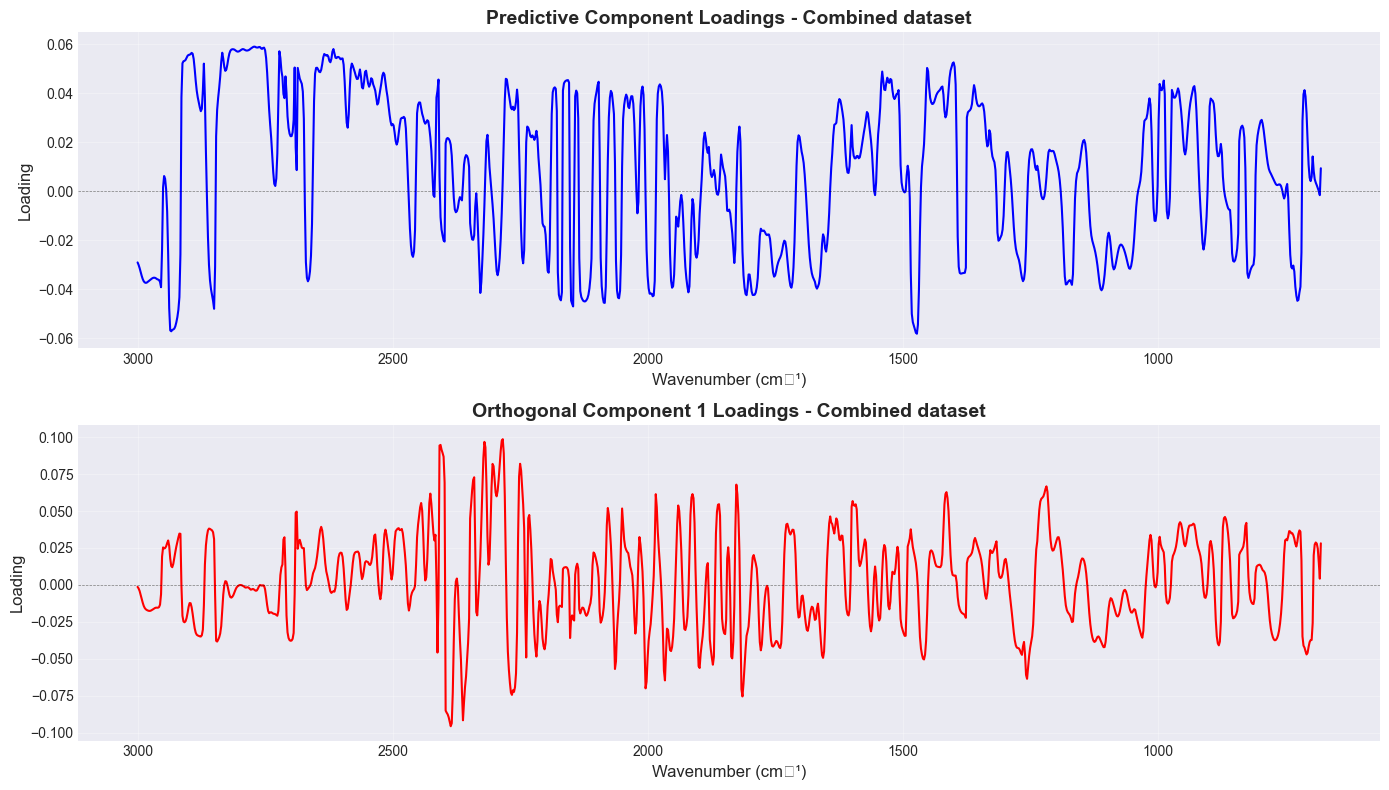

In [16]:
# OPLS-DA: Orthogonal PLS-DA
# n_components=1: Predictive components
# n_orthogonal=2: Orthogonal (uncorrelated) components
# Separates class-related variation from unrelated variation
fda.plot_oplsda(
    n_components=1,
    n_orthogonal=2,
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

---

## Step 7: Clustering Analysis

Clustering discovers natural groupings in unlabeled data. Compare clustering results to true labels to assess data structure.

### 7.1 K-means Clustering

K-means partitions data into k clusters by minimizing within-cluster variance. Good for spherical, well-separated clusters.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)
Performing K-Means Clustering for Combined dataset...
  Using 10 PCA components for clustering


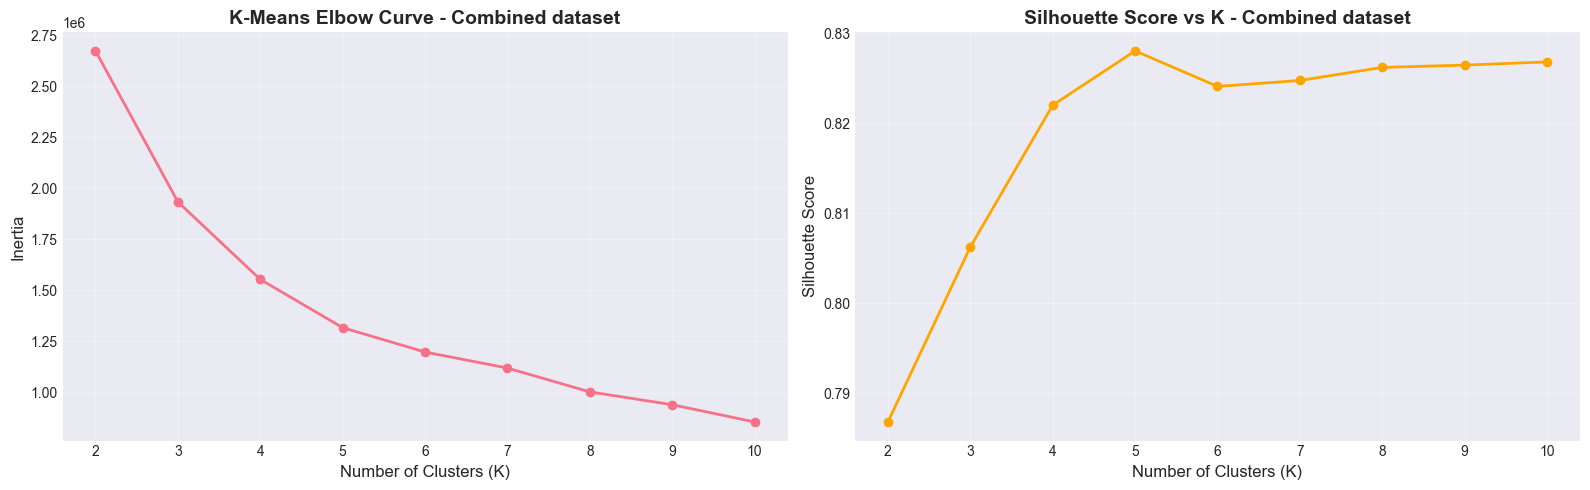


K-Means Clustering Summary for Combined dataset:
  Number of clusters: 8
  Silhouette Score: 0.826 (higher is better, range [-1, 1])
  Davies-Bouldin Score: 1.183 (lower is better)
  Calinski-Harabasz Score: 2014.99 (higher is better)


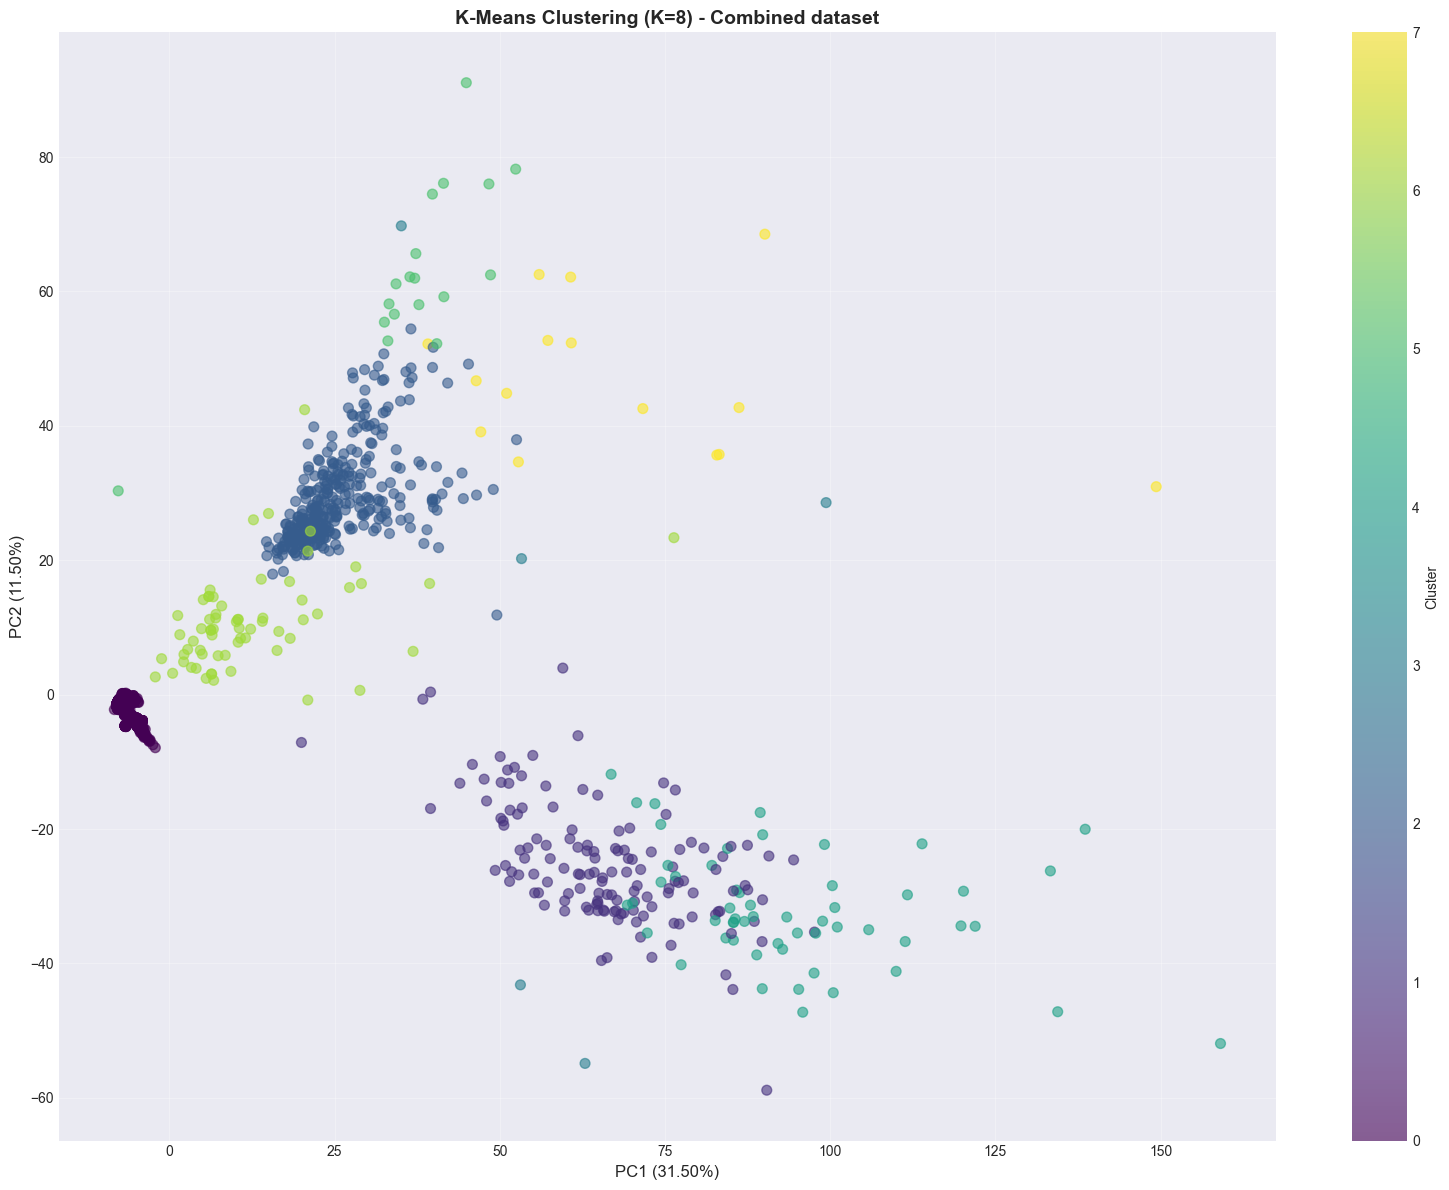

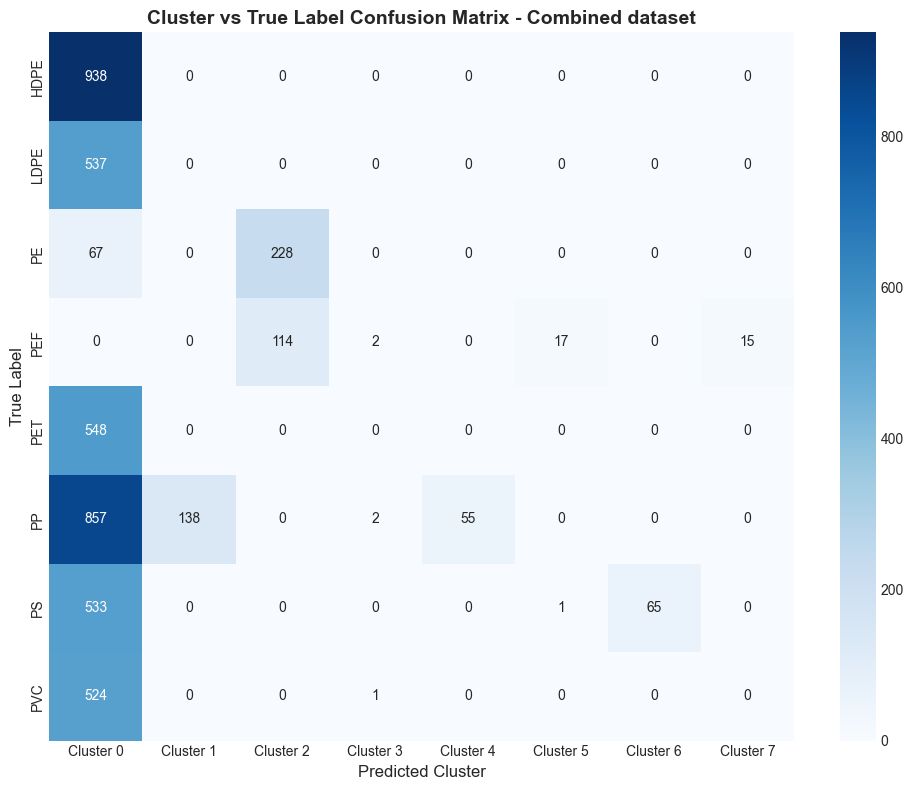

In [17]:
# K-means clustering
# n_clusters=8: Number of clusters (should match number of polymer types)
# pca_components=20: Reduce to 20 dimensions before clustering
# n_components_clustering=10: Use first 10 PCA components for clustering
# k_range=(2,11): Test elbow method for optimal k
# Look for:
#   - Agreement between clusters and true polymer types
#   - Elbow in within-cluster sum of squares plot
fda.plot_kmeans_clus(
    n_clusters=8,
    pca_components=20,
    n_components_clustering=10,
    k_range=(2, 11),
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

### 7.2 Hierarchical Clustering

Hierarchical clustering builds a tree of clusters (dendrogram). Useful for understanding hierarchical relationships between polymer types.

  Replaced NaN values with 0
Data standardized (mean=0, std=1)
Performing Hierarchical Clustering for Combined dataset...
  Using 10 PCA components for clustering
  Linkage method: ward


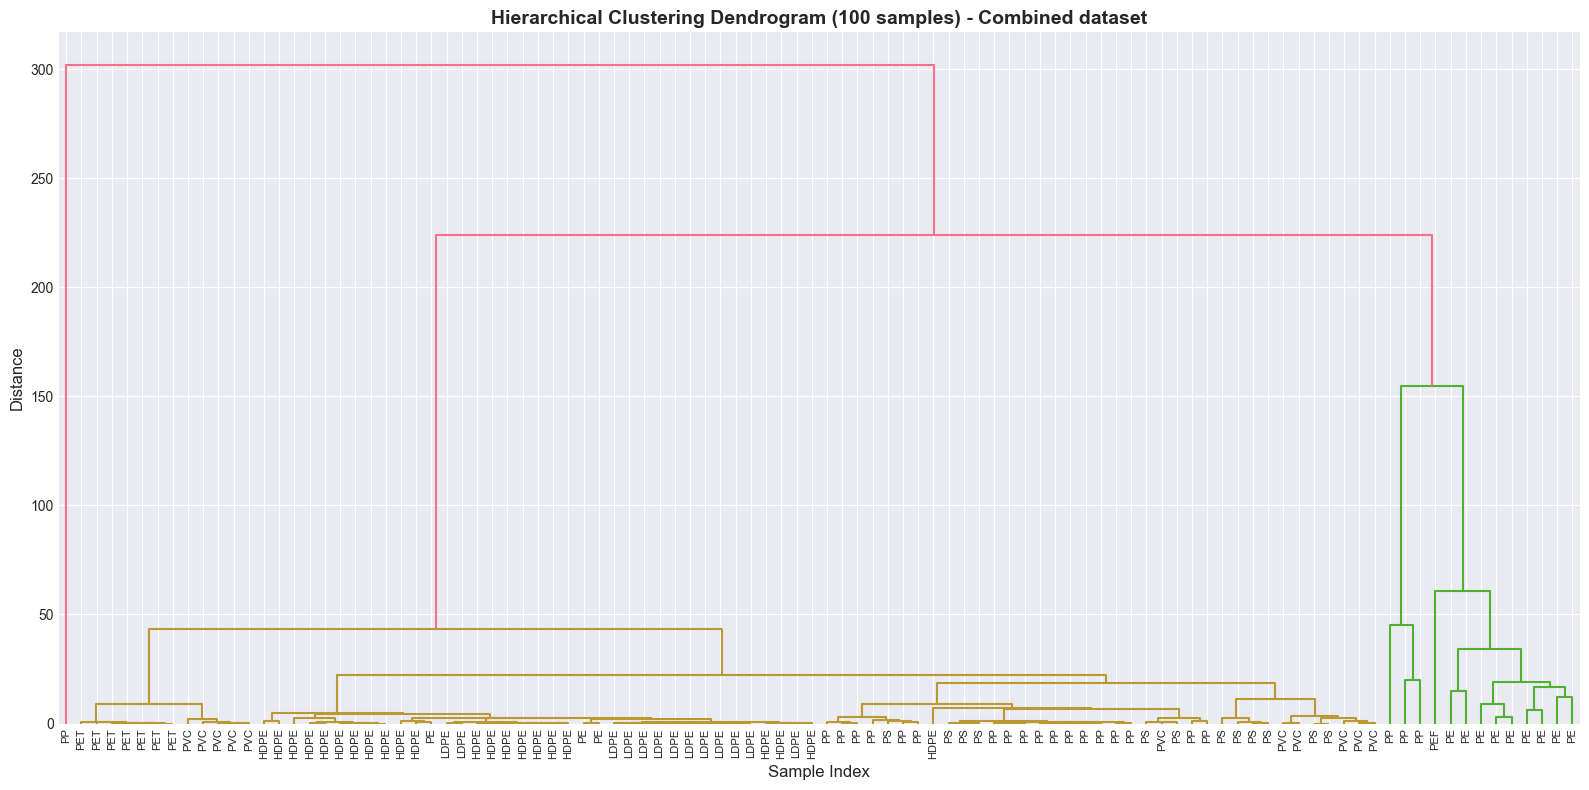


Hierarchical Clustering Summary for Combined dataset:
  Number of clusters: 8
  Silhouette Score: 0.821 (higher is better, range [-1, 1])
  Davies-Bouldin Score: 1.209 (lower is better)
  Calinski-Harabasz Score: 1962.77 (higher is better)


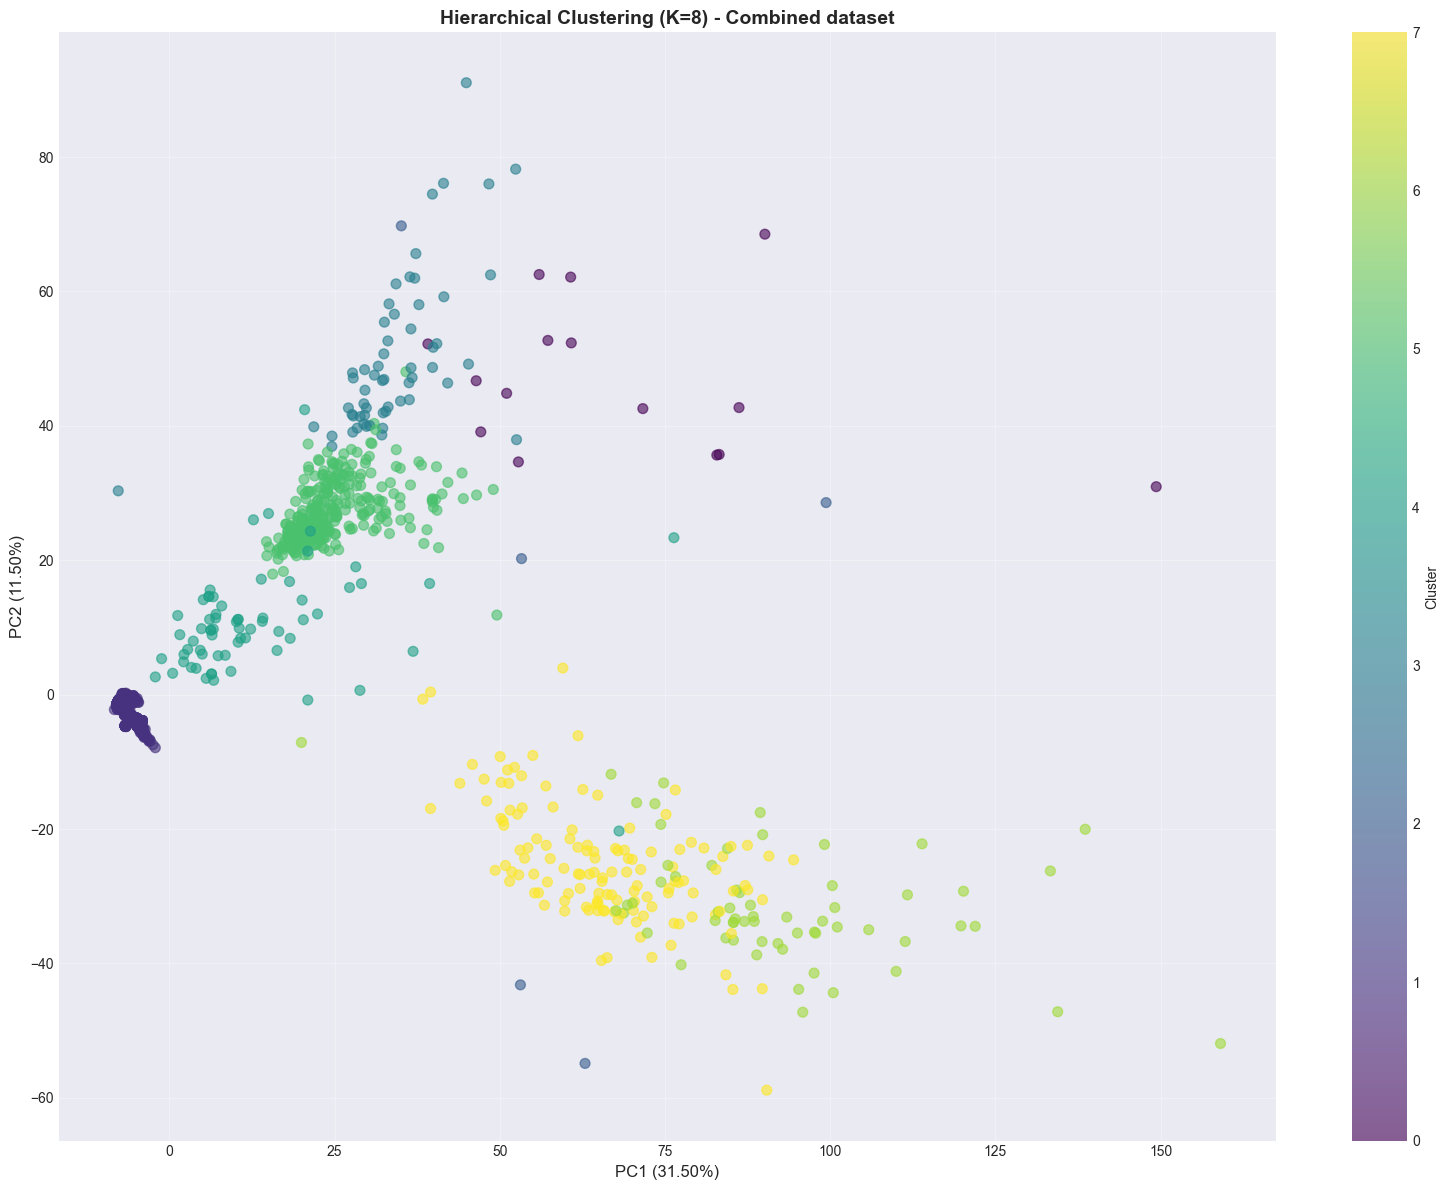

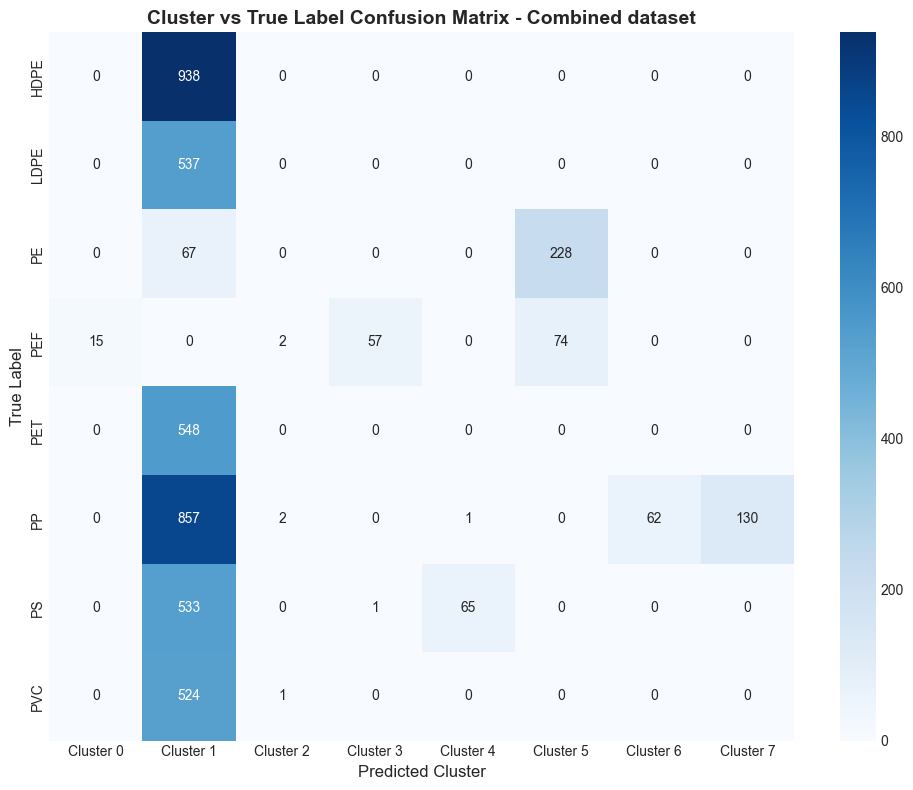

In [18]:
# Hierarchical clustering
# n_clusters=8: Cut dendrogram to form 8 clusters
# pca_components=20: Pre-reduce dimensionality
# n_components_clustering=10: Use 10 PCA components for clustering
# n_samples_dendro=100: Plot dendrogram for 100 samples (faster)
# Look for:
#   - Dendrogram structure (which polymers cluster together)
#   - Height of merges (distance between clusters)
fda.plot_hierarchical_clus(
    n_clusters=8,
    pca_components=20,
    n_components_clustering=10,
    n_samples_dendro=100,
    standardize=True,
    handle_missing="zero",
    figsize=(16, 12),
    save_plot=False,
    save_path=None,
)

---

## Step 8: Machine Learning Classification

Now we'll train and evaluate machine learning models to classify polymer types based on FTIR spectra.

### 8.1 Prepare Data for Machine Learning

Split data into training and testing sets.

In [19]:
print("\n" + "="*80)
print("PREPARING DATA FOR MACHINE LEARNING")
print("="*80)

# Prepare data for ML: split into training and testing sets
# test_size=0.2: Use 20% of data for testing, 80% for training
# Stratified split ensures balanced representation of each polymer type
data_dict = fda.ml_prepare_data(
    test_size=0.2,
)

print(f"\n✓ Data prepared successfully")
print(f"  Training samples: {len(data_dict['X_train'])}")
print(f"  Testing samples: {len(data_dict['X_test'])}")
print("="*80)


PREPARING DATA FOR MACHINE LEARNING
  Replaced NaN values with 0

✓ Data prepared successfully
  Training samples: 3713
  Testing samples: 929


### 8.2 Available Models

Xpectrass provides 40 pre-configured classification models across different algorithm families.

In [20]:
# View all available pre-configured models
# Includes: Linear models, tree-based, SVMs, neural networks, ensemble methods
print("\n" + "="*80)
print("AVAILABLE CLASSIFICATION MODELS")
print("="*80)
print(fda.available_models())
print("="*80)


AVAILABLE CLASSIFICATION MODELS
{'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42), 'Ridge Classifier': RidgeClassifier(random_state=42), 'Logistic Regression (Ridge)': LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l2', random_state=42,
                   solver='saga'), 'Logistic Regression (Lasso)': LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=42,
                   solver='saga'), 'Logistic Regression (ElasticNet)': LogisticRegression(l1_ratio=0.5, max_iter=1000, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga'), 'Linear Discriminant Analysis': LinearDiscriminantAnalysis(), 'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(shrinkage='auto', solver='eigen'), 'SGD Classifier': SGDClassifier(n_jobs=-1, random_state=42), 'SGD Classifier (Ridge)': SGDClassifier(n_jobs=-1, random_state=42), 'SGD Classifier (Lasso)': SGDClassifier(n_jobs=-1, penalty='l1', random_state=42)

### 8.3 Train and Evaluate a Single Model

Train a single model (XGBoost) and evaluate its performance.


TRAINING SINGLE MODEL: XGBoost (100)
  Replaced NaN values with 0


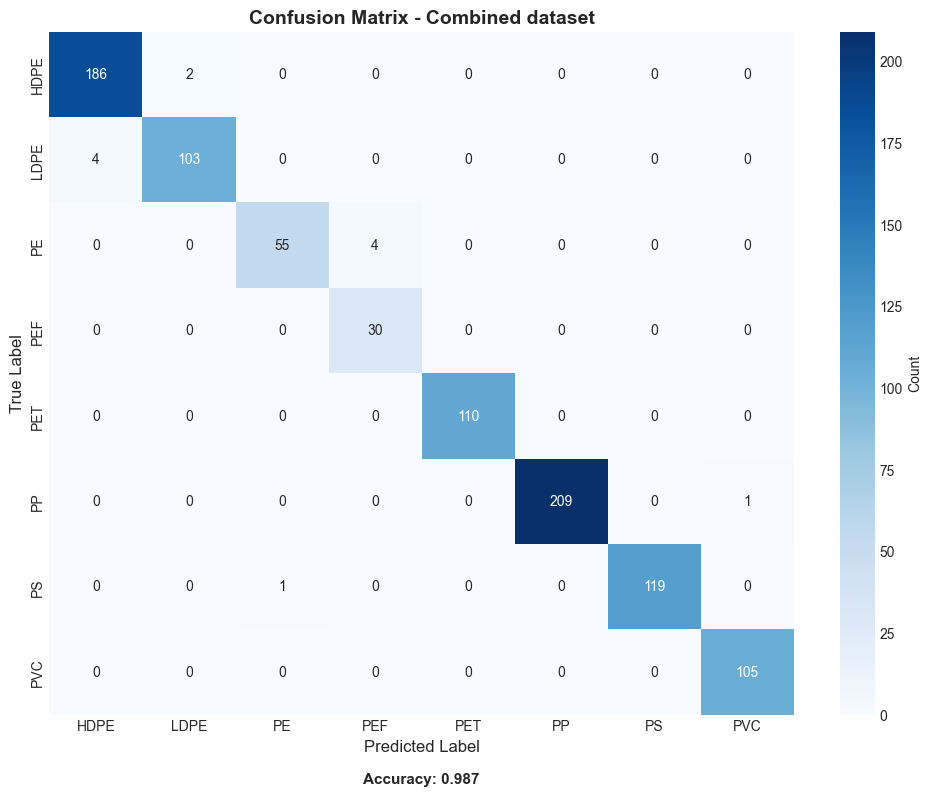

OVERALL METRICS:
--------------------------------------------------------------------------------
  Accuracy:              0.9871
  Precision (macro):     0.9769
  Precision (weighted):  0.9875
  Recall (macro):        0.9839
  Recall (weighted):     0.9871
  F1 (macro):            0.9798
  F1 (weighted):         0.9871
  MCC:                   0.9848
  Cohen's Kappa:         0.9847
  Jaccard (macro):       0.9613
  Jaccard (weighted):    0.9750
  ROC-AUC:               N/A (no probabilities)
Overall Results:
 {'accuracy': 0.9870828848223897, 'precision_macro': 0.9768701981785763, 'precision_weighted': 0.9875462441270717, 'recall_macro': 0.9838858345366046, 'recall_weighted': 0.9870828848223897, 'f1_macro': 0.9798170955885995, 'f1_weighted': 0.9871328719465996, 'mcc': 0.9847606155648926, 'cohens_kappa': 0.9847363362277884, 'jaccard_macro': 0.9612743169905144, 'jaccard_weighted': 0.9750252392615832, 'roc_auc_ovr_macro': nan, 'roc_auc_ovr_weighted': nan}
Per Class Results:
   class  supp

In [21]:
print("\n" + "="*80)
print("TRAINING SINGLE MODEL: XGBoost (100)")
print("="*80)

# Train and evaluate XGBoost model
# model_name: Use pre-configured model
# cv_folds=5: Use 5-fold cross-validation
# plot_confusion=True: Show confusion matrix
# print_test_result=True: Print detailed metrics
results = fda.run_a_model(
    model_name='XGBoost (100)',
    model=None,
    cv_folds=5,
    plot_confusion=True,
    save_plot_path=None,
    print_test_result=True,
)

print("="*80)

### 8.4 Train and Compare All Models

Train all 35+ models and compare their performance. This identifies the best models for your data.


TRAINING AND COMPARING ALL MODELS
This will train 35+ models and may take several minutes...

  Replaced NaN values with 0

EVALUATING ALL MODELS - Combined dataset

[1/41] Evaluating Logistic Regression...
  ✓ Accuracy: 0.9828 | Train time: 0.21s
[2/41] Evaluating Ridge Classifier...
  ✓ Accuracy: 0.9182 | Train time: 0.03s
[3/41] Evaluating Logistic Regression (Ridge)...
  ✓ Accuracy: 0.9526 | Train time: 49.74s
[4/41] Evaluating Logistic Regression (Lasso)...
  ✓ Accuracy: 0.9537 | Train time: 90.58s
[5/41] Evaluating Logistic Regression (ElasticNet)...
  ✓ Accuracy: 0.9537 | Train time: 97.60s
[6/41] Evaluating Linear Discriminant Analysis...
  ✓ Accuracy: 0.8913 | Train time: 0.26s
[7/41] Evaluating Quadratic Discriminant Analysis...
  ERROR: The covariance matrix of class 0 is not full rank. Increase the value of `shrinkage` to reduce the collinearity.
  ✗ Failed
[8/41] Evaluating SGD Classifier...
  ✓ Accuracy: 0.9839 | Train time: 0.45s
[9/41] Evaluating SGD Classifier (Ridge)

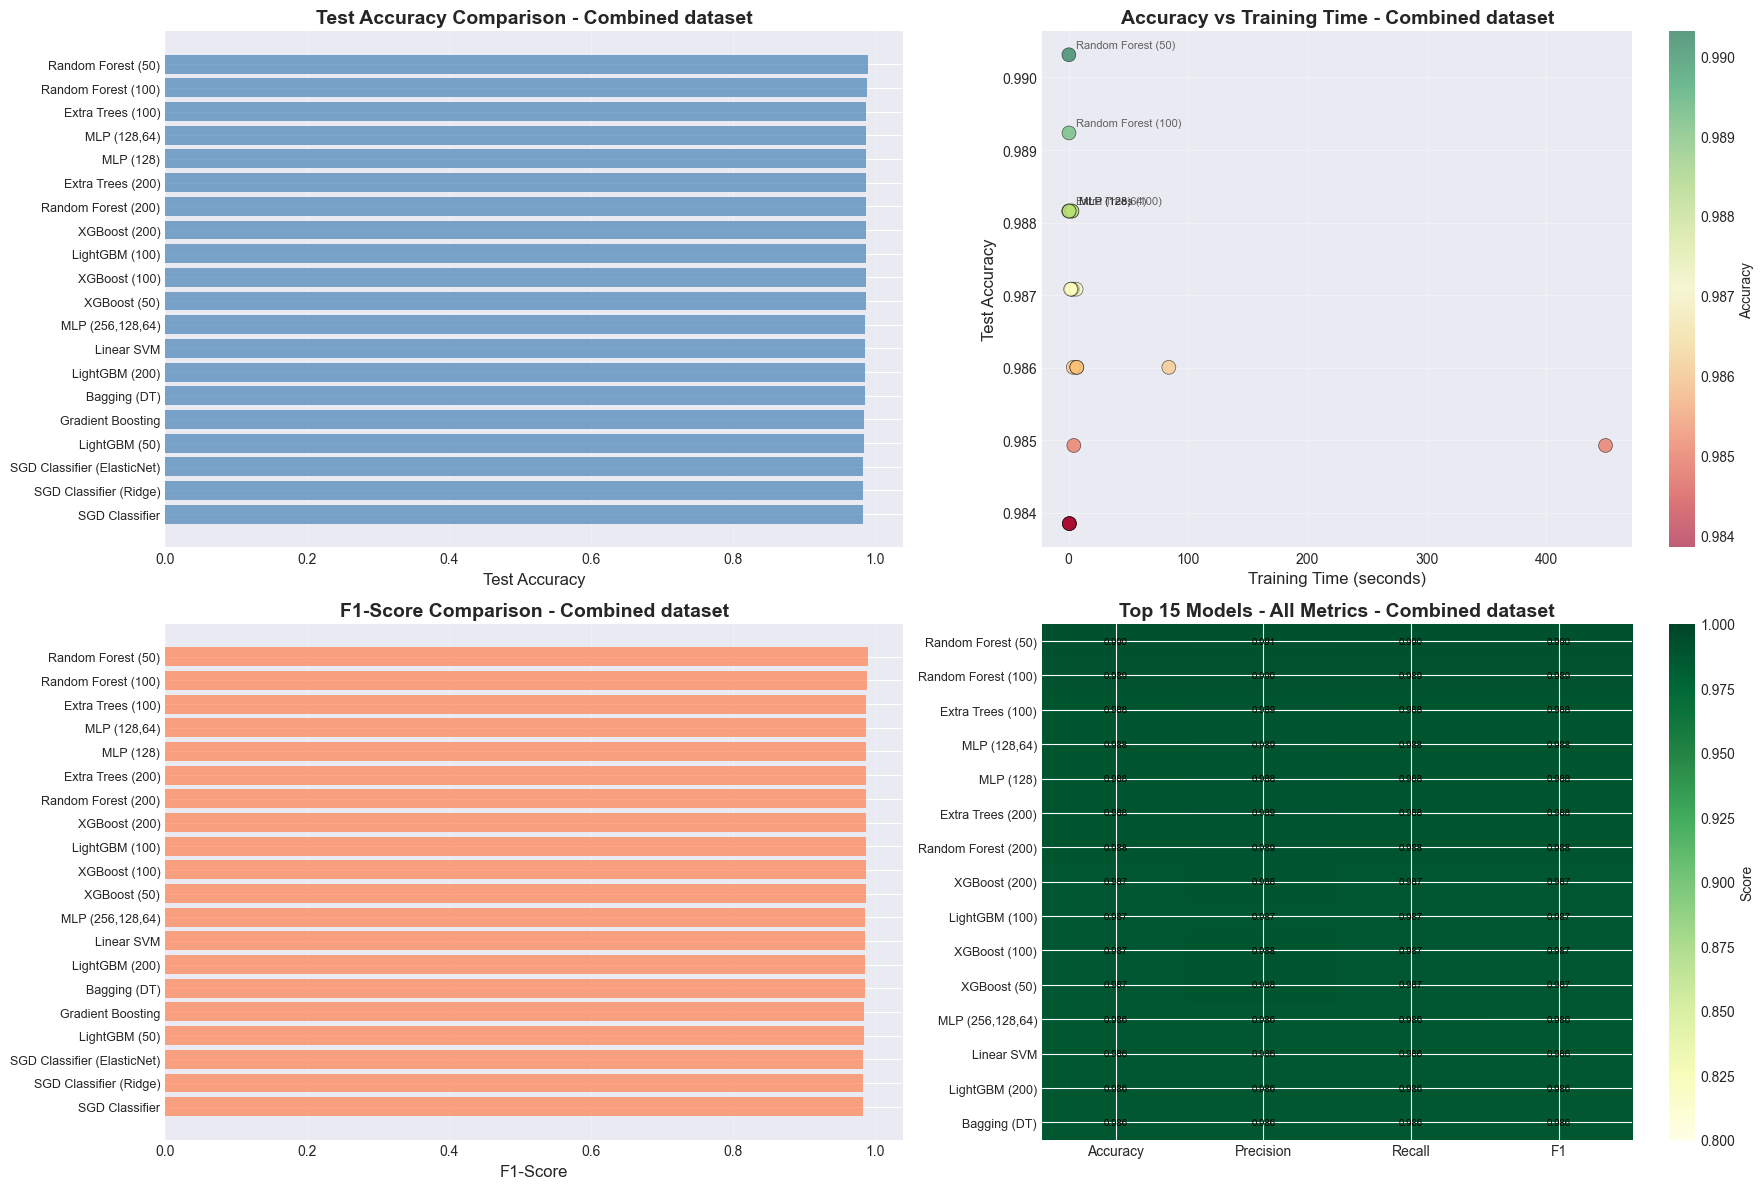


MODEL FAMILY COMPARISON - Combined dataset

        family  test_accuracy_mean  test_accuracy_max  test_accuracy_min  test_accuracy_std  train_time_mean  train_time_median  pred_time_mean  pred_time_median  model_name_count
    Tree-Based              0.9871             0.9903             0.9785             0.0043           0.3685             0.1827          0.0144            0.0149                 6
Neural Network              0.9851             0.9882             0.9817             0.0033           2.5210             2.6134          0.0011            0.0010                 5
      Boosting              0.9664             0.9871             0.8267             0.0564          62.4188             5.2077          0.0088            0.0044                 8
       Bagging              0.9860             0.9860             0.9860                NaN           6.7200             6.7200          0.1627            0.1627                 1
           SVM              0.8138             0.9860  

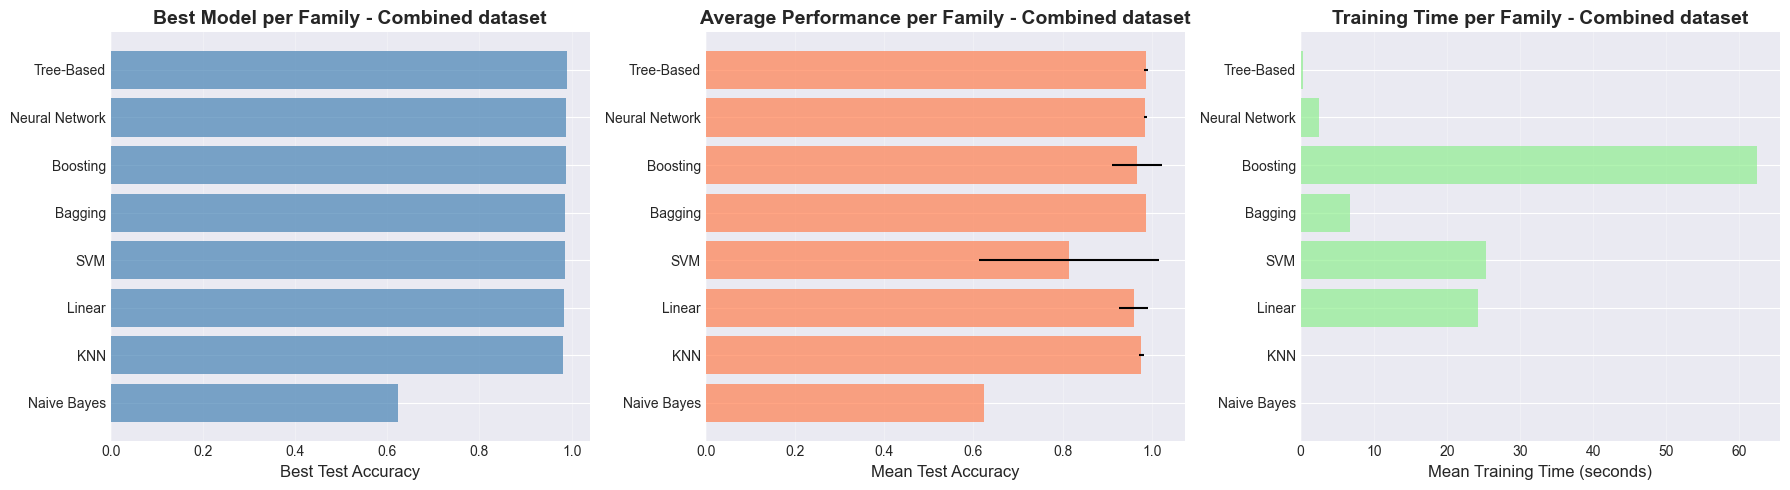

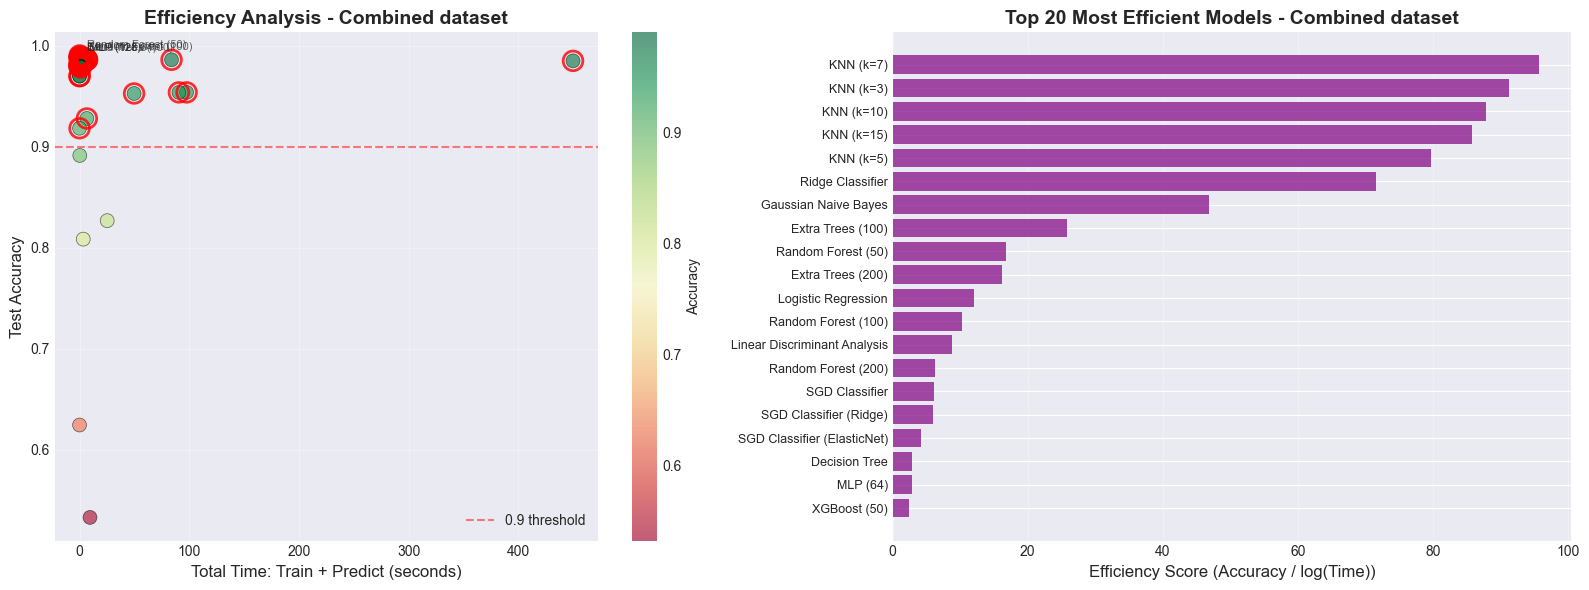


TOP 10 MOST EFFICIENT MODELS - Combined dataset

          model_name  test_accuracy  total_time  efficiency_score
           KNN (k=7)       0.979548    0.023840         95.733094
           KNN (k=3)       0.980624    0.025060         91.226284
          KNN (k=10)       0.969860    0.025749         87.840981
          KNN (k=15)       0.969860    0.026350         85.862550
           KNN (k=5)       0.979548    0.028699         79.713967
    Ridge Classifier       0.918192    0.029970         71.596422
Gaussian Naive Bayes       0.624327    0.031115         46.916399
   Extra Trees (100)       0.988159    0.092370         25.753584
  Random Forest (50)       0.990312    0.146012         16.731301
   Extra Trees (200)       0.988159    0.150736         16.205755


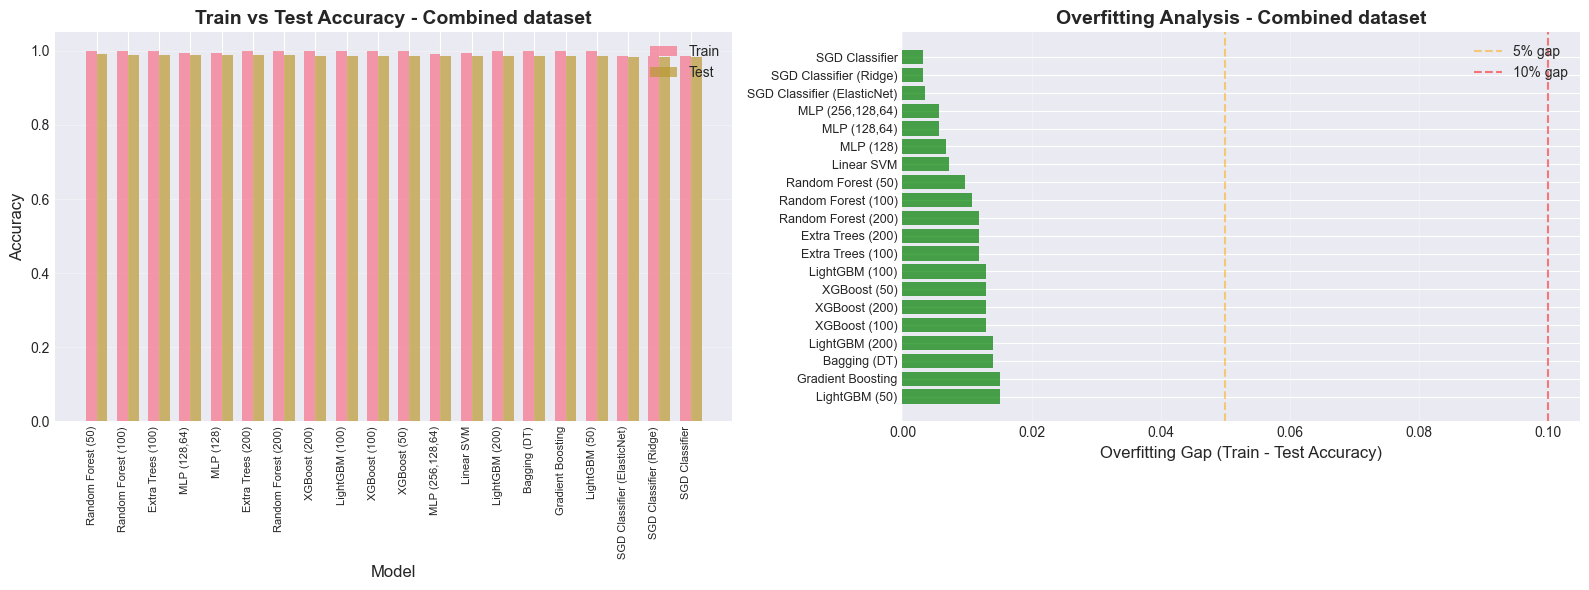


MODELS WITH LEAST OVERFITTING - Combined dataset

                 model_name  train_accuracy  test_accuracy  overfit_gap
             SGD Classifier        0.987072       0.983854     0.003219
     SGD Classifier (Ridge)        0.987072       0.983854     0.003219
SGD Classifier (ElasticNet)        0.987342       0.983854     0.003488
           MLP (256,128,64)        0.991651       0.986006     0.005644
               MLP (128,64)        0.993806       0.988159     0.005646
                  MLP (128)        0.994883       0.988159     0.006724
                 Linear SVM        0.993267       0.986006     0.007260
         Random Forest (50)        1.000000       0.990312     0.009688
        Random Forest (100)        1.000000       0.989236     0.010764
        Random Forest (200)        1.000000       0.988159     0.011841

MODEL COMPARISON COMPLETE


In [22]:
print("\n" + "="*80)
print("TRAINING AND COMPARING ALL MODELS")
print("="*80)
print("This will train 35+ models and may take several minutes...\n")

# Train all available models and compare performance
# plot_comparision=True: Show comparison plots
# accuracy_threshold=0.9: Only show models with >90% accuracy
# top_n_methods=20: Show top 20 models
results_all = fda.run_all_models(
    plot_comparision=True,
    accuracy_threshold=0.9,
    top_n_methods=20,
    save_plot_path=None
)

print("\n" + "="*80)
print("MODEL COMPARISON COMPLETE")
print("="*80)

### 8.5 Hyperparameter Tuning

Fine-tune the top model(s) by optimizing hyperparameters using grid search.

In [23]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)
print("Tuning top model(s) using grid search with cross-validation...\n")

# Perform hyperparameter tuning on the top model
# number_of_models=1: Tune only the best model
# Uses grid search with cross-validation
tuning_results = fda.model_parameter_tuning(number_of_models=1)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*80)


HYPERPARAMETER TUNING
Tuning top model(s) using grid search with cross-validation...


HYPERPARAMETER TUNING FOR TOP 1 MODELS


Tuning Random Forest (50)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
  Original Accuracy: 0.9903
  Tuned Accuracy: 0.9914
  Improvement: +0.0011
  Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

HYPERPARAMETER TUNING COMPLETE


---

## Step 9: Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) explains model predictions by showing which features (wavenumbers) contribute most to each prediction.

### 9.1 Global SHAP Analysis

Shows overall feature importance across all predictions.


SHAP EXPLAINABILITY ANALYSIS
  Replaced NaN values with 0

SHAP FEATURE IMPORTANCE ANALYSIS

Data mode: Using SCALED data for SHAP computation, RAW data for visualization

Sampling 100 background samples from 3713 training samples...

Model: XGBClassifier
Using TreeExplainer (fast for tree-based models)...
Computing SHAP values for 929 test samples...


 99%|===================| 7322/7432 [00:23<00:00]        

SHAP computation completed in 23.06s

Multiclass problem detected: 8 classes

Using 'grid' layout for 8 classes

Generating SHAP summary plots for each class...


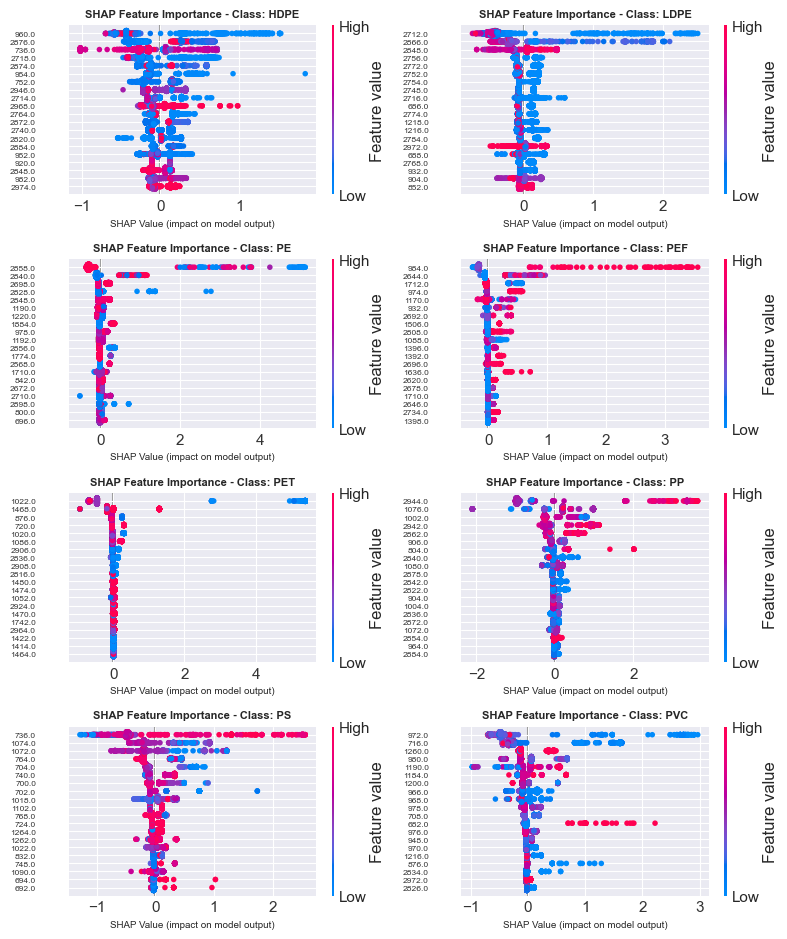


Generating SHAP bar plots (mean absolute impact)...


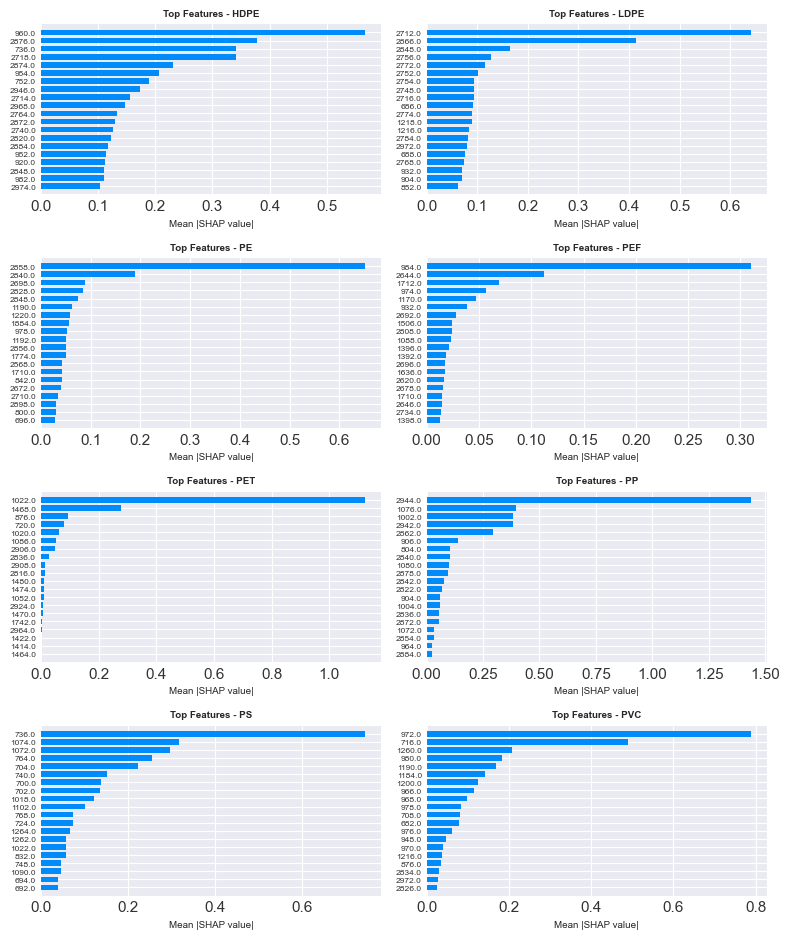


Generating combined global feature importance plot...


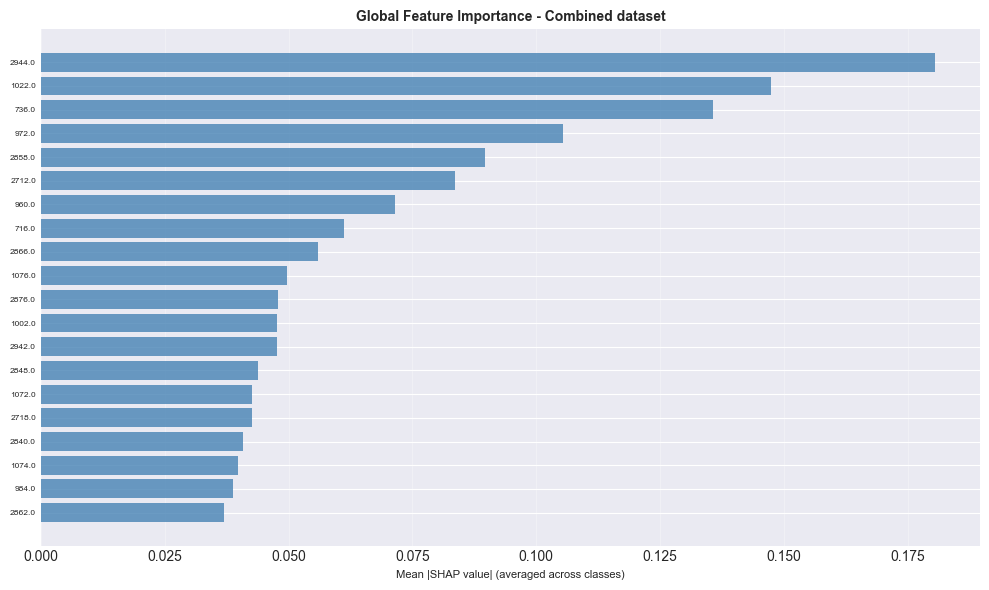


TOP 10 FEATURES PER CLASS (by mean absolute SHAP value)

HDPE:
----------------------------------------
   1.      960.0  |  Impact: 0.5660
   2.     2876.0  |  Impact: 0.3770
   3.      736.0  |  Impact: 0.3415
   4.     2718.0  |  Impact: 0.3404
   5.     2874.0  |  Impact: 0.2319
   6.      954.0  |  Impact: 0.2068
   7.      752.0  |  Impact: 0.1895
   8.     2946.0  |  Impact: 0.1728
   9.     2714.0  |  Impact: 0.1567
  10.     2968.0  |  Impact: 0.1463

LDPE:
----------------------------------------
   1.     2712.0  |  Impact: 0.6400
   2.     2866.0  |  Impact: 0.4146
   3.     2848.0  |  Impact: 0.1644
   4.     2756.0  |  Impact: 0.1272
   5.     2772.0  |  Impact: 0.1157
   6.     2752.0  |  Impact: 0.1007
   7.     2754.0  |  Impact: 0.0941
   8.     2748.0  |  Impact: 0.0931
   9.     2716.0  |  Impact: 0.0926
  10.      686.0  |  Impact: 0.0914

PE:
----------------------------------------
   1.     2858.0  |  Impact: 0.6510
   2.     2840.0  |  Impact: 0.1896
   3.    

In [24]:
print("\n" + "="*80)
print("SHAP EXPLAINABILITY ANALYSIS")
print("="*80)

# Explain model predictions with SHAP
# model_name: Which model to explain
# max_display=20: Show top 20 most important features
# sample_size=100: Use 100 samples for SHAP (faster, representative)
# Generates:
#   - Summary plot (feature importance)
#   - Bar plot (mean absolute SHAP values)
#   - Beeswarm plot (feature effects)
shap_results = fda.explain_by_shap(
    model_name='XGBoost (100)',
    max_display=20,
    sample_size=100,
    test_size=0.2,
    cv_folds=5,
    save_plot_path=None
)

print("\n✓ SHAP analysis complete")
print("="*80)

### 9.2 Local SHAP Analysis

Explains a single prediction by showing which features pushed the model toward or away from each class.


SHAP Decision Plot for Sample 0
True Label: HDPE


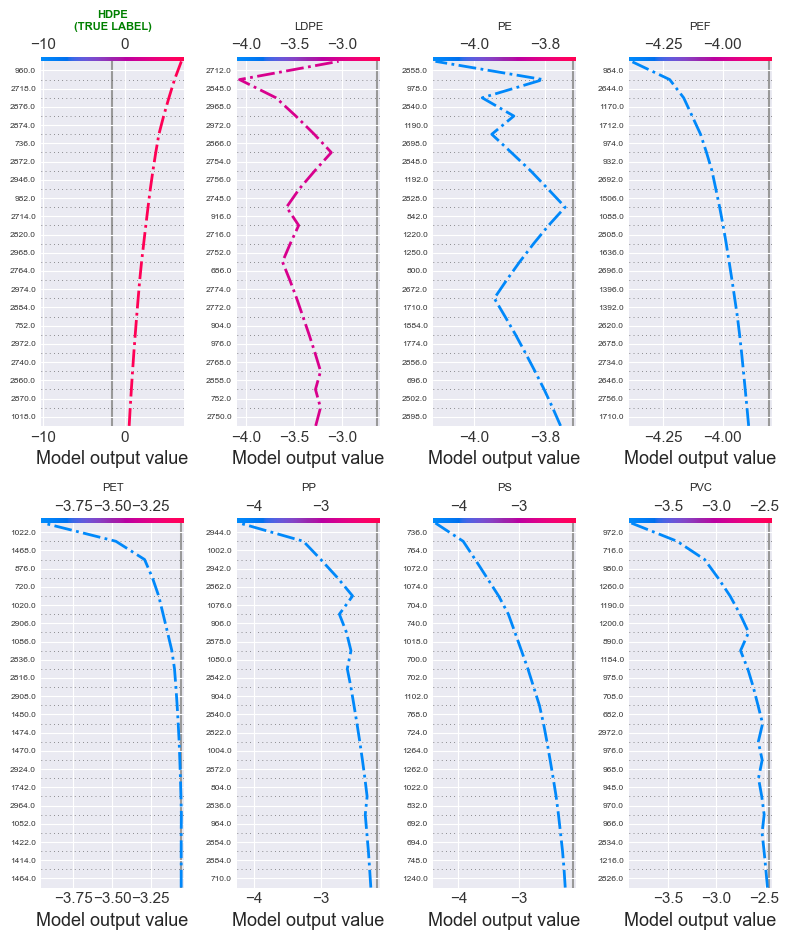

In [25]:
# Local SHAP plot for a single prediction
# sample_index=0: Explain prediction for first test sample
# Shows:
#   - Base value (average model output)
#   - How each feature pushes prediction toward final value
#   - Red = pushes prediction higher, Blue = pushes lower
fda.local_shap_plot(
    sample_index=0,
    figsize=(10, 8),
    save_plot_path=None
)

---

## Summary and Conclusions

### What We Accomplished

In this notebook, we performed a comprehensive analysis of FTIR spectral data:

1. ✓ **Data Loading & Filtering**: Loaded and filtered preprocessed data
2. ✓ **Exploratory Visualization**: Visualized spectral patterns and variability
3. ✓ **Statistical Analysis**: Identified discriminative wavenumbers (ANOVA, correlation)
4. ✓ **Dimensionality Reduction**: Reduced data to 2D for visualization (PCA, t-SNE, UMAP, PLS-DA, OPLS-DA)
5. ✓ **Clustering**: Discovered natural groupings (K-means, hierarchical)
6. ✓ **Machine Learning**: Trained and compared 35+ classification models
7. ✓ **Model Interpretation**: Explained predictions with SHAP

### Key Insights

From the analysis, you should now understand:

- **Spectral Signatures**: Each polymer type has characteristic FTIR peaks
- **Discriminative Features**: Which wavenumbers are most useful for classification (ANOVA, SHAP)
- **Data Structure**: How polymer types cluster in reduced dimensions
- **Model Performance**: Which models work best for your data
- **Feature Importance**: Which spectral regions drive model predictions

### Best Practices

- **Always visualize first**: Understand your data before modeling
- **Try multiple methods**: Different algorithms have different strengths
- **Use cross-validation**: Ensures robust performance estimates
- **Interpret models**: SHAP helps understand what models learn
- **Consider domain knowledge**: Combine statistical results with chemical understanding

### Next Steps

Depending on your research goals, you can:

1. **Improve Models**:
   - Try different preprocessing methods (Notebooks 1-3)
   - Perform feature selection (use ANOVA, SHAP results)
   - Try deep learning models
   - Ensemble multiple models

2. **Analyze New Samples**:
   - Use trained models to classify unknown samples
   - Calculate prediction confidence
   - Identify outliers or contaminated samples

3. **Publication**:
   - Save high-quality plots (set `save_plot=True`)
   - Export results for further analysis
   - Document your methodology

### Tips for Interpretation

- **High accuracy isn't everything**: Consider precision, recall, and F1-score
- **Confusion matrix**: Shows which polymer types are confused
- **SHAP values**: Reveal which wavenumbers matter most
- **Cross-validation scores**: Show model stability
- **Domain knowledge**: Use chemistry to validate statistical findings

### Additional Resources

- Xpectrass documentation: [docs link]
- FTIR spectroscopy guides
- Machine learning best practices
- Chemometrics literature

---

## Conclusion

You've completed a comprehensive analysis of FTIR spectral data! The visualizations, statistical analyses, and machine learning models provide deep insights into polymer classification. Use these results to inform your research and build robust classification systems.